In [48]:
# Add outsourcers, who can sell labor to firms in frictionless markets

import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe
from numba import jit, njit, prange, vectorize
from scipy import optimize
from IPython.core.debugger import set_trace

# Want to vectorize cost of vacancy, marginal cost of vacancy, and inverse marginal cost of vacancy
@vectorize
def C(v, gamma, k_grid):
    return k_grid * v**gamma

@vectorize
def c(v, gamma, k_grid):
    return k_grid * gamma * v**(gamma - 1)
     
@vectorize
def c_inv(c, gamma, k_grid):
    if c > 0:
        return (c / gamma / k_grid)**(1 / (gamma - 1))
    else:
        return 0

# Do the same for outsourcers
@vectorize
def C_h(v, gamma_h, k_h):
    return k_h * v**gamma_h

@vectorize
def c_h(v, gamma_h, k_h):
    if v > 0:
        return k_h * gamma_h * v**(gamma_h - 1)
    else:
        return 0
     
@vectorize
def c_h_inv(c, gamma_h, k_h):
    if c > 0:
        return (c / gamma_h / k_h)**(1 / (gamma_h - 1))
    else:
        return 0
    
# Set up the baseline environment, starting with a discrete model
class OutsourcerDiscrete:
    """
    B is discount rate beta
    r is interest rate defined by beta
    b is home production
    delta is job loss rate
    delta_hat is firm destruction rate <= delta
    eta is workers bargaining power with firm
    eta_h is workers bargaining power with outsourcer
    phi is effectiveness of matching function
    q is firm's matching function, worker's is p=theta*q(theta)
    y_min, y_max, y_grid_size determine productivity grid
    gamma is steepness of marginal cost, k_grid is level of entry cost
    gamma_h is steepness of marginal cost for outsourcer, k_h is level of cost
    q is matching function of firms
    p is matching function of workers
    
    q_p is derivative of firm's matching function for Planner's
    p_p is derivative of worker's matching function for Planner's
    
    barg is 1 if firms can use outsourcer as outside option with workers, 0 else
    """
    def __init__(
        self, B, b, delta, delta_hat, eta, eta_h, phi,
        y_min, y_max, y_grid_size, gamma, gamma_h, k_grid, k_h, barg=0
    ):
        
        self.B, self.b, self.delta, self.eta, self.gamma, self.k_grid = B, b, delta, eta, gamma, k_grid
        self.delta_hat, self.eta_h, self.gamma_h, self.k_h = delta_hat, eta_h, gamma_h, k_h 
        self.r = 1 / B - 1
        
        self.y_grid = np.linspace(y_min, y_max, y_grid_size)
        self.y_grid_size = y_grid_size        
        
        self.q = njit(lambda x: min(phi * x**(-1 / 2), 1))
        self.p = njit(lambda x: min(phi * x**(1 / 2), 1))
        # Remember, q_p and p_p = 0 if q or p = 1
        self.q_p = njit(lambda x: -phi / 2 * x**(-3 / 2) * (phi * x**(-1 / 2) < 1)) 
        self.p_p = njit(lambda x: phi / 2 * x**(1 / 2) * (phi * x**(1 / 2) < 1))
        
        self.barg = barg
        
# Set up needed functions
def operator_factory(out):
    
    r, b, delta, eta, gamma, k_grid = out.r, out.b, out.delta, out.eta, out.gamma, out.k_grid
    delta_hat, eta_h, gamma_h, k_h = out.delta_hat, out.eta_h, out.gamma_h, out.k_h
    y_grid, y_grid_size = out.y_grid, out.y_grid_size
    y_grid_max = max(y_grid)
    q, p = out.q, out.p
    barg = out.barg
    
    # Find wages for each postion
    @njit()
    def wages(v_grid, v_h, u, y_hat, p_h):
        firm_sum = np.sum(c(v_grid[y_grid < y_hat], gamma, k_grid[y_grid < y_hat]) * v_grid[y_grid < y_hat])
        out_sum = c_h(v_h, gamma_h, k_h) * v_h        
        w_grid = (b + eta * (y_grid - b + (firm_sum + (1 - eta) * eta_h / ((1 - eta_h) * eta) * out_sum) / u) 
                  - barg * eta * (r + delta) / (r + delta_hat) * np.maximum(y_grid - p_h, 0))
        omega = b + eta_h * (p_h - b + ((1 - eta_h) * eta / ((1 - eta) * eta_h) * firm_sum + out_sum) / u)
        return w_grid, omega 
     
    # Find y_hat_new using prices
    @njit()
    def get_y_hat(p_h, w_grid, theta):
        
        J = (y_grid - w_grid) / (r + delta)
        J_H = (y_grid - p_h) / (r + delta_hat)
        choice = 1 * (J_H >= q(theta) * J) * (J_H > 0) 
        ind = np.searchsorted(choice, 0, side='right')
        # If y_hat > y_max, return y_max + 1
        if ind < y_grid_size:
            y_hat = y_grid[ind]
        else:
            y_hat = y_grid_max + 1
        return y_hat
    
    # Find quantity supplied and quantity demanded for outsourcing
    @njit()
    def find_QS_QD(v_grid, v_h, u, y_hat):
        
        theta = (np.sum(v_grid[y_grid < y_hat]) + v_h) / u
        # Supply of outsourcing are matched outsourcers, not outsourcer vacancies
        QS = v_h * q(theta) / delta
        # Demand for outsourcing are matched firms, not firm vacancies
        QD = np.sum(v_grid[y_grid >= y_hat]) / delta_hat
        return QS, QD
    
    @njit()
    def iterate(v_grid, v_h, u, y_hat, p_h):
        
        # Set theta and wages
        theta = (np.sum(v_grid[y_grid < y_hat]) + v_h) / u
        w_grid, omega = wages(v_grid, v_h, u, y_hat, p_h)    
        
        v_grid_new = np.empty(y_grid_size)       
        
        # Update y_hat
        y_hat_new = get_y_hat(p_h, w_grid, theta)
        
        # Should the relevant comparison be y_hat or y_hat_new? Make switching easier
        y_comp = y_hat
        
        # Firms who hire own workers (below y_comp)
        v_grid_new[y_grid < y_comp] = (
            c_inv(q(theta) * (y_grid[y_grid < y_comp] - w_grid[y_grid < y_comp]) / (r + delta),
                  gamma, k_grid[y_grid < y_comp]))
        
        # Firms who outsource workers (above y_comp)
        v_grid_new[y_grid >= y_comp] = (
            c_inv((y_grid[y_grid >= y_comp] - p_h) / (r + delta_hat), gamma, k_grid[y_grid >= y_comp]))
        
        # v_h_new chosen using free entry
        v_h_new = c_h_inv(q(theta) * (p_h - omega) / (r + delta), gamma_h, k_h)
        
        # Update u_new using employed workers
        n_grid_b = q(theta) * v_grid_new[y_grid < y_comp] / delta
        u_new = max(1 - np.sum(n_grid_b) - (q(theta) * v_h_new / delta), 1e-6)

        return v_grid_new, v_h_new, u_new, y_hat_new
    
    return iterate, wages, get_y_hat, find_QS_QD

# Solve model given p_h 
def solve_given_p(out, p_h, v_grid, v_h, u, y_hat, tol, max_iter, slow):
    
    iterate, _, _, _ = operator_factory(out)
    
    # Set up initial loop parameters
    i = 0
    err = tol + 1    
    
    # Update v_grid, v_h, u, and y_hat each period
    while i < max_iter and err > tol:
        v_grid_new, v_h_new, u_new, y_hat_new = iterate(v_grid, v_h, u, y_hat, p_h)
        err_v = np.max(np.abs(v_grid_new - v_grid))
        err_v_h = np.abs(v_h_new - v_h)
        err_u = np.abs(u_new - u)
        err_y_hat = np.abs(y_hat_new - y_hat)
        err = max(err_v, err_v_h, err_u, err_y_hat)
        i += 1
        
        v_grid = slow * v_grid_new + (1 - slow) * v_grid
        v_h = slow * v_h_new + (1 - slow) * v_h        
        u = slow * u_new + (1 - slow) * u
        y_hat = slow * y_hat_new + (1 - slow) * y_hat
        
    return v_grid_new, v_h_new, u_new, y_hat_new

# Find p_h by bisection
def find_p(
    out, tol, max_iter, p_low, p_high, tol_p, max_iter_p, slow_p=1, verbose=True, print_skip=100
):
    
    iterate, wages, get_y_hat, find_QS_QD = operator_factory(out)
    
    b, eta, r, delta, delta_hat = out.b, out.eta, out.r, out.delta, out.delta_hat 
    gamma, gamma_h, k_grid, k_h, q = out.gamma, out.gamma_h, out.k_grid, out.k_h, out.q
    y_grid, y_grid_size = out.y_grid, out.y_grid_size  
    
    # Set up loop parameters    
    err = tol + 1
    j = 0
    test = []
    
    # Find QD - QS for p_low and p_high, make sure they have opposite signs
    for p_h in [p_low, p_high]:
        # Initial guesses
        v_grid = np.ones(y_grid_size) / y_grid_size
        u = 0.05
        y_hat = p_h
        v_h = np.sum(v_grid[y_grid >= y_hat]) * (r + delta) / (r + delta_hat)
        
        v_grid, v_h, u, y_hat = solve_given_p(out, p_h, v_grid, v_h, u, y_hat, tol_p, max_iter_p, slow_p)
        QS, QD = find_QS_QD(v_grid, v_h, u, y_hat)
        test.append(QD - QS)
        
        if verbose:
            print(f'Error for price {p_h} is {QD - QS}')
            
    if np.cumprod(test)[1] > 0:
        print('Test failed, both prices have positive/negative excess demand')
        return
    
    while err > tol and j < max_iter:
        p_h = (p_low + p_high) / 2
        # Initial guesses
        v_grid = np.ones(out.y_grid_size) / out.y_grid_size
        u = 0.05
        y_hat = p_h
        v_h = np.sum(v_grid[y_grid >= y_hat]) * (r + delta) / (r + delta_hat)
        
        v_grid, v_h, u, y_hat = solve_given_p(out, p_h, v_grid, v_h, u, y_hat, tol_p, max_iter_p, slow_p)
        QS, QD = find_QS_QD(v_grid, v_h, u, y_hat)
        err = np.abs(QD - QS)
        
        # If excess demand QD - QS > 0, set p_low = p_h, otherwise p_high = p_h
        if QD - QS > 0:
            p_low = p_h
        else:
            p_high = p_h
            
        if verbose and j % print_skip == 0:
            print(f'Error at iter {j} is {err}; price is {p_h}; QS is {QS}; QD is {QD}')
            
        j += 1
    
    if j < max_iter:
        print(f'Converged in {j} iterations, error is {err}; price is {p_h}; QS is {QS}; QD is {QD}')
    if j == max_iter:
        print(f'Failed to Converge. Error is {err}; price is {p_h}; QS is {QS}; QD is {QD}')
        
    return v_grid, v_h, u, y_hat, p_h

# Can check code against theoretical results by looking at spread and number of entrants
# For spread of entrants, 3 comparisons
# 1. Above y_hat, compare to y_max
# 2. Below y_hat, compare to y_max
# 3. Below y_hat, compare to y_hat (or largest y below y_hat)
# Graph results
# Keep in mind that spread_theory doesn't know that vacancies cannot be negative
def spread(out, v_grid, v_h, u, y_hat, p_h,
           save=False, folder=r'C:\Users\spspi\Dropbox\Documents\Outsourcing\Figures',
           file=r'\Outsourcers\spread.pdf'):
    
    gamma, k_grid, eta, r, delta, delta_hat = out.gamma, out.k_grid, out.eta, out.r, out.delta, out.delta_hat
    eta_h, gamma_h, k_h = out.eta_h, out.gamma_h, out.k_h
    q, y_grid = out.q, out.y_grid
    barg = out.barg
    
    theta = (np.sum(v_grid[out.y_grid < y_hat]) + v_h) / u
    
    i_m = np.argmax(y_grid[v_grid > 0])    
    i_y = np.searchsorted(y_grid, y_hat)
    
    spread_theory_1 = (c(v_grid[i_m], gamma, k_grid[i_m]) - c(v_grid, gamma, k_grid)) * (r + delta_hat)
    
    spread_theory_2 = (c(v_grid[i_m], gamma, k_grid[i_m]) * (r + delta_hat) 
                       - (c(v_grid, gamma, k_grid) / (1 - eta) - c_h(v_h, gamma_h, k_h) 
                          / (1 - eta_h)) * (r + delta) / q(theta)
                      + barg * eta * (r + delta) / ((1 - eta) * (r + delta_hat)) * np.maximum(y_grid - p_h, 0))
    
    spread_theory_3 = ((c(v_grid[i_y], gamma, k_grid[i_y]) - c(v_grid, gamma, k_grid)) * (r + delta)
                       / ((1 - eta) * q(theta))
                       - barg * eta * (r + delta) / ((1 - eta) * (r + delta_hat)) 
                       * (np.maximum(y_grid[i_y] - p_h, 0) - np.maximum(y_grid - p_h, 0)))
    
    spread_prod_y_max = y_grid[i_m] - y_grid
    spread_prod_y_max[v_grid == 0] = spread_theory_2[v_grid == 0]
    spread_prod_y_hat = y_grid[i_y] - y_grid
    spread_prod_y_hat[v_grid == 0] = spread_theory_3[v_grid == 0]
    
    dif_1 = spread_prod_y_max - spread_theory_1
    dif_2 = spread_prod_y_max - spread_theory_2
    dif_3 = spread_prod_y_hat - spread_theory_3
    
    fig, ax = plt.subplots()
    ax.plot(y_grid, spread_prod_y_max, lw=2, alpha=0.7, label='Productivity $y_{max}$')
    ax.plot(y_grid[:i_y], spread_prod_y_hat[:i_y], lw=2, alpha=0.7, label=r'Productivity $\hat{y}$')
    ax.plot(y_grid[i_y:], spread_theory_1[i_y:], lw=2, alpha=0.7, label='Theoretical 1')
    ax.plot(y_grid[:i_y], spread_theory_2[:i_y], lw=2, alpha=0.7, label='Theoretical 2')
    ax.plot(y_grid[:i_y], spread_theory_3[:i_y], lw=2, alpha=0.7, label='Theoretical 3')
    ax.set(xlabel='$y$', ylabel='Spread', title='Spread of Vacancies')
    ax.legend(loc='best')
    ax.grid()
    
    if save:
        fig.savefig(folder + file)
    else:
        plt.show()   
        
    fig, ax = plt.subplots()
    ax.plot(y_grid[i_y:], dif_1[i_y:], lw=2, alpha=0.7, label='Above')
    ax.plot(y_grid[:i_y], dif_2[:i_y], lw=2, alpha=0.7, label='Above-Below')
    ax.plot(y_grid[:i_y], dif_3[:i_y], lw=2, alpha=0.7, label='Below')
    ax.set(xlabel='$y$', ylabel='Spread', title='Difference in Spread of Vacancies')
    ax.legend(loc='best')
    ax.grid()
    ax.ticklabel_format(axis='y', style='sci', scilimits=(1,-1))
    
    if save:
        fig.savefig(folder + file + '_dif')
    else:
        plt.show() 
        
# For number of vacancies, look at above and below y_hat
def entry(out, v_grid, v_h, u, y_hat, p_h):
    
    gamma, k_grid, eta, r, delta, delta_hat = out.gamma, out.k_grid, out.eta, out.r, out.delta, out.delta_hat
    eta_h, gamma_h, k_h = out.eta_h, out.gamma_h, out.k_h
    q, p, y_grid = out.q, out.p, out.y_grid
    barg = out.barg
    
    theta = (np.sum(v_grid[y_grid < y_hat]) + v_h) / u 
    firm_sum_a = np.sum(c(v_grid[y_grid >= y_hat], gamma, k_grid[y_grid >= y_hat]) * v_grid[y_grid >= y_hat])
    firm_sum = np.sum(c(v_grid[y_grid < y_hat], gamma, k_grid[y_grid < y_hat]) * v_grid[y_grid < y_hat])
    out_sum = c_h(v_h, gamma_h, k_h) * v_h
    v_tilde = np.sum(v_grid[y_grid < y_hat])
    v_hat = np.sum(v_grid[y_grid >= y_hat])
    sum_barg = np.sum(np.maximum(y_grid[y_grid < y_hat] - p_h, 0) * v_grid[y_grid < y_hat])
    
    entry_code_a = np.sum(v_grid[y_grid >= y_hat] * (y_grid[y_grid >= y_hat] - b))
    entry_code_b = np.sum(v_grid[y_grid < y_hat] * (y_grid[y_grid < y_hat] - b))
    
    entry_theory_a = ((r + delta_hat) * firm_sum_a + eta * v_hat / (u * (1 - eta)) * firm_sum
                      + delta_hat * (r + delta + eta_h * v_h * q(theta) / u ) / ((1 - eta_h) * delta) * out_sum)
    entry_theory_b = ((r + delta + eta * q(theta) * v_tilde / u) / ((1 - eta) * q(theta)) * firm_sum
                      + eta_h * v_tilde / (u * (1 - eta_h)) * out_sum 
                      - barg * eta * (r + delta) / (r + delta_hat) * sum_barg)
    
    print(f'Entry above from code gives {entry_code_a:.4f}; entry from theory gives {entry_theory_a:.4f}')
    print(f'Entry below from code gives {entry_code_b:.4f}; entry from theory gives {entry_theory_b:.4f}')
    
    # While doing this, also check if u is consistent with LOM
    u_t = delta / (delta + p(theta))    
    print(f'unemployment in model is {u:.4f}; according to LOM, should be {u_t:.4f}')
    # Probably related to whether p and q are < 1. Check these
    print(f'Employees match w/prob {p(theta):.2f}, employers match w/prob {q(theta):.2f}')
    
# Create a pdf of wage distribution
def out_wage_dist(v_grid, v_h, y_hat, w_grid, omega,
           save=False, folder=r'C:\Users\spspi\Dropbox\Documents\Outsourcing\Figures',
                  file=r'\Outsourcers\wage_dist.pdf'):
    
    y_grid = out.y_grid  
    
    w_plot = w_grid[(v_grid > 0) * (y_grid < y_hat)]
    v_pdf = v_grid[(v_grid > 0) * (y_grid < y_hat)] / sum(v_grid[y_grid < y_hat])
    
    fig, ax = plt.subplots()
    ax.plot(w_plot, v_pdf, alpha=0.7, color='b', label='Firms')
    ax.fill_between(w_plot, 0, v_pdf, alpha=0.1, color='b')
    ax.vlines(omega, 0, 1, alpha=0.7, color='r', label='Outsourcer')
    space = 2e-5
    ax.set_ylim(-space, max(v_pdf) + space)
    ax.set(xlabel='Wages', ylabel='Density')
    ax.legend(title="Worker's Employer", loc='best')
    ax.ticklabel_format(axis='y', style='sci', scilimits=(1,-1))
    
    if save:
        fig.savefig(folder + file + '.pdf')
    else:
        plt.show()   

Error for price 0 is 41.44049095300378
Error for price 10 is -0.6248575660626341
Error at iter 0 is 4.92265214564381; price is 5.0; QS is 0.13572368043067382; QD is 5.058375826074484
Error at iter 10 is 0.0017371004230308795; price is 7.0263671875; QS is 0.25842026936538565; QD is 0.25668316894235477
Error at iter 20 is 0.0006480206517820442; price is 7.023682594299316; QS is 0.25960491314779144; QD is 0.2589568924960094
Failed to Converge. Error is 0.0006472668489792; price is 7.0236781891435385; QS is 0.25960460066562097; QD is 0.25895733381664177
0.08219683757678292 0.4357853456068542 0.7574146366557256 0.3300701992027053
7.0236781891435385 0.010282529070676826
Entry above from code gives 0.0245; entry from theory gives 0.0244
Entry below from code gives 0.1725; entry from theory gives 0.1770
unemployment in model is 0.0822; according to LOM, should be 0.0833
Employees match w/prob 0.33, employers match w/prob 0.76


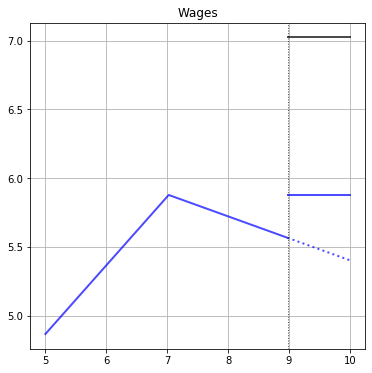

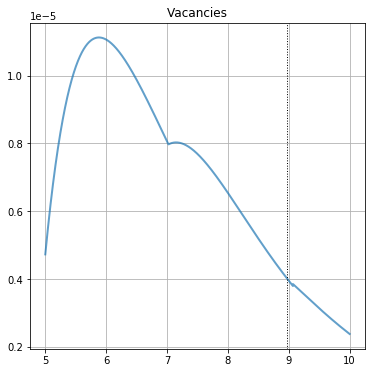

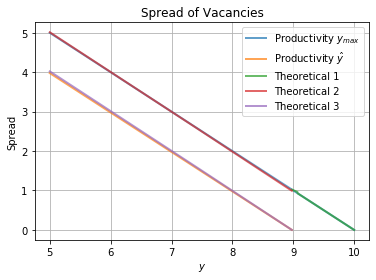

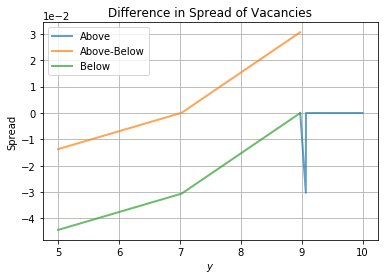

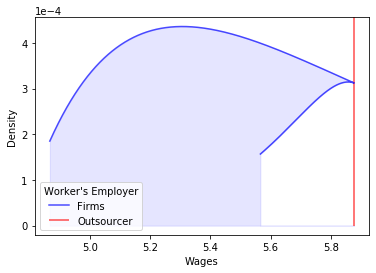

In [2]:
B = 0.95
r = 1 / B - 1
b = 0
delta = 0.03
eta = 0.5
eta_h = 0.5
# phi = 1
phi = 5e-1 
# y_min = 1
y_min = 5
y_max = 10
y_grid_size = 4000
gamma = 2
delta_hat = 0.01
gamma_h = 2
# k_grid = np.logspace(4, 5.5, y_grid_size)
k_grid = np.logspace(5, 7, y_grid_size)
k_h = 5e2
barg = 1

out = OutsourcerDiscrete(
    B, b, delta, delta_hat, eta, eta_h, phi, y_min, y_max, y_grid_size, gamma, gamma_h, k_grid, k_h, barg
)

tol = 1e-8
tol_p = 1e-8
max_iter = 30
max_iter_p = 1e4
print_skip = 10
slow_p = 1e-3
p_low = 0
p_high = y_max + 1

v_grid, v_h, u, y_hat, p_h = find_p(
    out, tol, max_iter, p_low, p_high, tol_p, max_iter_p, slow_p=slow_p, verbose=True, print_skip=print_skip
)

iterate, wages, get_y_hat, find_QS_QD = operator_factory(out)

w_grid, omega = wages(v_grid, v_h, u, y_hat, p_h)

theta = (np.sum(v_grid[out.y_grid < y_hat]) + v_h) / u

# print(theta * ((1 - pi) * np.sum(c(v_grid, gamma) * f_grid) + pi * c_h(v_h, gamma_h)))
print(u, theta, out.q(theta), out.p(theta))
print(p_h, v_h)
# print(np.sum(v_grid))

entry(out, v_grid, v_h, u, y_hat, p_h)

# Plot v_grid and w_grid with y_hat dotted vert line
# Wage has dotted horizontal line for p and omega, Vacancy has a dotted horizontal line for v_h
omega_grid = omega * np.ones(y_grid_size)
p_h_grid = p_h * np.ones(y_grid_size)
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(out.y_grid[out.y_grid < y_hat], w_grid[out.y_grid < y_hat], lw=2, alpha=0.7, c='b')
ax.plot(out.y_grid[out.y_grid >= y_hat], w_grid[out.y_grid >= y_hat], lw=2, alpha=0.7, c='b', linestyle=':')
ax.axvline(x=y_hat, c='k', lw=1, linestyle=':', alpha=0.7)
ax.plot(out.y_grid[out.y_grid >= y_hat], omega_grid[out.y_grid >= y_hat], lw=2, alpha=0.7, c='b')
ax.plot(out.y_grid[out.y_grid >= y_hat], p_h_grid[out.y_grid >= y_hat], lw=2, alpha=0.7, c='k')
ax.grid()
ax.set_title("Wages")

plt.show()

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(out.y_grid, v_grid, lw=2, alpha=0.7)
ax.axvline(x=y_hat, c='k', lw=1, linestyle=':')
# ax.axhline(y=v_h, c='k', lw=2, linestyle='--')
ax.ticklabel_format(axis='y', style='sci', scilimits=(1,-1))
ax.grid()
ax.set_title("Vacancies")

plt.show()

spread(out, v_grid, v_h, u, y_hat, p_h)

out_wage_dist(v_grid, v_h, y_hat, w_grid, omega)

In [27]:
%debug

> <ipython-input-25-d3f61542ed32>(380)out_wage_dist()
    378 
    379         for i, w in enumerate(w_plot):
--> 380             v_pdf[i] += sum(v_grid[w_grid[i_m:] == w])
    381 
    382 

ipdb> print(w)
4.86618
ipdb> sum(v_grid[w_grid[i_m:] == w])
*** IndexError: boolean index did not match indexed array along dimension 0; dimension is 4000 but corresponding boolean dimension is 2381
ipdb> w_grid[i_m:]
array([5.87792, 5.87773, 5.87753, ..., 5.40321, 5.40301, 5.40281])
ipdb> c


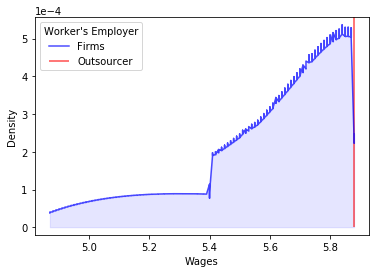

In [43]:
out_wage_dist(v_grid, v_h, y_hat, w_grid, omega)

In [17]:
np.round(w_grid, 4)

array([4.8662, 4.8668, 4.8674, ..., 5.4032, 5.403 , 5.4028])

In [14]:
# Run top cell first
# Create graphs for various p_h

def graphing(out, p_h_min, p_h_max, p_h_grid_size, tol=1e-4, max_iter=1000, slow=1/100,
           save=False, folder=r'C:\Users\spspi\Dropbox\Documents\Outsourcing\Figures', file=r'\Outsourcers\SD'):
    
    delta, eta, eta_h, y_grid, q, p = out.delta, out.eta, out.eta_h, out.y_grid, out.q, out.p
    gamma, k_grid, gamma_h, k_h = out.gamma, out.k_grid, out.gamma_h, out.k_h
    y_grid_size = out.y_grid_size
        
    p_h_grid = np.linspace(p_h_min, p_h_max, p_h_grid_size, endpoint=False)
    
    iterate, wages, get_y_hat, find_QS_QD = operator_factory(out)
    
    # Create grid for QS and QD
    QS_grid, QD_grid = np.empty(p_h_grid_size), np.empty(p_h_grid_size)
    # Create a grid for theta, v_h, and va_grid (vacancies above y_hat)
    theta_grid, v_h_grid, v_a_grid = np.empty(p_h_grid_size), np.empty(p_h_grid_size), np.empty(p_h_grid_size)
    # Create grid for total firms and vacancies
    v_tot_grid, n_tot_grid = np.empty(p_h_grid_size), np.empty(p_h_grid_size)
    # Create grid for y_hat, omega, and val_search
    y_hat_grid, omega_grid, val_search_grid = np.empty(p_h_grid_size), np.empty(p_h_grid_size), np.empty(p_h_grid_size)
    # Create a grid for percent of matching with outsourcer (pi) and percent firms outsourcing
    pi_grid, per_out_grid = np.empty(p_h_grid_size), np.empty(p_h_grid_size)
    # Create a grid for u and theoretical u from lom
    u_grid, u_lom_grid = np.empty(p_h_grid_size), np.empty(p_h_grid_size)
    # Create grids for p and q
    p_grid, q_grid = np.empty(p_h_grid_size), np.empty(p_h_grid_size)
    # Record the maximum price with poistive demand, start by assuming p_h_max
    i_max = int(p_h_max)
    
    
    # For each p_h, find QS and QD, which requires finding theta too
    for i, p_h in enumerate(p_h_grid):
        
        # Initial guesses
        v_grid = np.ones(y_grid_size) / y_grid_size
        u = 0.05
        y_hat = p_h
        v_h = np.sum(v_grid[y_grid >= y_hat]) * (r + delta) / (r + delta_hat)
        
        v_grid, v_h, u, y_hat = solve_given_p(out, p_h, v_grid, v_h, u, y_hat, tol, max_iter, slow)
        
        QS_grid[i], QD_grid[i] = find_QS_QD(v_grid, v_h, u, y_hat)
        w_grid, omega = wages(v_grid, v_h, u, y_hat, p_h)
        theta = (np.sum(v_grid[y_grid < y_hat]) + v_h) / u
        v_tot_grid[i] = np.sum(v_grid)
        n_tot_grid[i] = QD_grid[i] + np.sum(v_grid[y_grid < y_hat]) * q(theta) / delta
        v_a_grid[i] = np.sum(v_grid[y_grid >= y_hat])
        v_h_grid[i] = v_h
        y_hat_grid[i] = y_hat
        theta_grid[i] = theta
        omega_grid[i] = omega
        u_grid[i] = u
        pi_grid[i] = 100 * v_h / (np.sum(v_grid[y_grid < y_hat]) + v_h)
        per_out_grid[i] = 100 * QD_grid[i] / n_tot_grid[i]
        val_search_grid[i] = ((eta / (1 - eta) * 
                               np.sum(c(v_grid[y_grid < y_hat], gamma, k_grid[y_grid < y_hat])
                                      * v_grid[y_grid < y_hat]) 
                               + eta_h / (1 - eta_h) * c_h(v_h, gamma_h, k_h) * v_h) / u)
        p_grid[i] = p(theta)
        q_grid[i] = q(theta)
        u_lom_grid[i] = delta / (delta + p(theta))
        
        # If QD_grid[i] == 0, stop the program and record i_max
        if QD_grid[i] == 0:
            i_max = i
            break
                
    fig, ax = plt.subplots()
    ax.plot(QS_grid[:i_max], p_h_grid[:i_max], lw=2, alpha=0.7, label='Supply')
    ax.plot(QD_grid[:i_max], p_h_grid[:i_max], lw=2, alpha=0.7, label='Demand')
    ax.set(xlabel='$n$', ylabel='$p_h$', title='Supply and Demand of Outsourcing')
    ax.legend(loc='best')
    ax.grid()
    
    if save:
        fig.savefig(folder + file)
    else:
        plt.show() 
        
    fig, ax = plt.subplots()
    ax.plot(QS_grid[:i_max], p_h_grid[:i_max], lw=2, alpha=0.7, label='Supply')
    ax.plot(v_h_grid[:i_max], p_h_grid[:i_max], lw=2, alpha=0.7, label='Vacancies')
    ax.set(xlabel='$n$', ylabel='$p_h$', title='Supply of Outsourcing vs Vacancies')
    ax.legend(loc='best')
    ax.grid()
    
    if save:
        fig.savefig(folder + file + '_Supply')
    else:
        plt.show()
        
    fig, ax = plt.subplots()
    ax.plot(QD_grid[:i_max], p_h_grid[:i_max], lw=2, alpha=0.7, label='Demand')
    ax.plot(v_a_grid[:i_max], p_h_grid[:i_max], lw=2, alpha=0.7, label='Vacancies')
    ax.set(xlabel='$n$', ylabel='$p_h$', title='Demand for Outsourcing vs Vacancies')
    ax.legend(loc='best')
    ax.grid()
    
    if save:
        fig.savefig(folder + file + '_Demand')
    else:
        plt.show()
        
    fig, ax = plt.subplots()
    ax.plot(p_h_grid[:i_max], QD_grid[:i_max] - QS_grid[:i_max], lw=2, alpha=0.7)
    ax.axhline(y=0, ls=':', c='k')
    ax.set(xlabel='$p_h$', ylabel=r'$QD - QS$', title='$QD - QS$ Given Price $p_h$')
    ax.grid()
    
    if save:
        fig.savefig(folder + file + '_qd_min_qs')
    else:
        plt.show()  
        
    fig, ax = plt.subplots()
    ax.plot(p_h_grid[:i_max], pi_grid[:i_max], lw=2, alpha=0.7)
    ax.set(xlabel='$p_h$', ylabel=r'%', title='Percent Chance of Matching with Outsourcer')
    ax.grid()
    
    if save:
        fig.savefig(folder + file + '_pi')
    else:
        plt.show()
        
    fig, ax = plt.subplots()
    ax.plot(p_h_grid[:i_max], per_out_grid[:i_max], lw=2, alpha=0.7)
    ax.set(xlabel='$p_h$', ylabel=r'%', title='Percent of Postions Outsourced')
    ax.grid()
    
    if save:
        fig.savefig(folder + file + '_per_out')
    else:
        plt.show() 
        
    fig, ax = plt.subplots()
    ax.plot(p_h_grid[:i_max], val_search_grid[:i_max], lw=2, alpha=0.7)
    ax.set(xlabel='$p_h$', ylabel=r'Value', title='Value of Search')
    ax.grid()
    
    if save:
        fig.savefig(folder + file + '_val_search')
    else:
        plt.show() 
        
    fig, ax = plt.subplots()
    ax.plot(p_h_grid[:i_max], theta_grid[:i_max], lw=2, alpha=0.7)
    ax.set(xlabel='$p_h$', ylabel=r'$\theta$', title='Market Tightness')
    ax.grid()
    
    if save:
        fig.savefig(folder + file + '_theta')
    else:
        plt.show() 
        
    fig, ax = plt.subplots()
    ax.plot(p_h_grid[:i_max], v_tot_grid[:i_max], lw=2, alpha=0.7, label=r'Vacancies')
    ax.plot(p_h_grid[:i_max], n_tot_grid[:i_max], lw=2, alpha=0.7, label=r'Firms')
    ax.set(xlabel='$p_h$', ylabel=r'$n/v$', title='Total Firms and Vacancies')
    ax.legend(loc='best')
    ax.grid()
    
    if save:
        fig.savefig(folder + file + '_tot_f_v')
    else:
        plt.show() 
        
    fig, ax = plt.subplots()
    ax.plot(p_h_grid[:i_max], p_grid[:i_max], lw=2, alpha=0.7, label=r'$p(\theta)$')
    ax.plot(p_h_grid[:i_max], q_grid[:i_max], lw=2, alpha=0.7, label=r'$q(\theta)$')
    ax.set(xlabel='$p_h$', ylabel=r'Matching Probability', title='Matching Probabilities')
    ax.legend()
    ax.grid()
    
    if save:
        fig.savefig(folder + file + '_match_prob')
    else:
        plt.show() 
        
        
    y_min = min(out.y_grid)
    y_max = max(out.y_grid)
    fig, ax = plt.subplots()
    ax.plot(p_h_grid[:i_max], y_hat_grid[:i_max], lw=2, alpha=0.7)
    ax.axhline(y=y_min, ls=':', c='k')
    ax.axhline(y=y_max, ls=':', c='k')
    ax.set(xlabel='$p_h$', ylabel='$y^*$', title='$y^*$ Given Price $p_h$')
    ax.grid()
    
    if save:
        fig.savefig(folder + file + '_y_hat')
    else:
        plt.show() 
        
    fig, ax = plt.subplots()
    ax.plot(p_h_grid[:i_max], omega_grid[:i_max], lw=2, alpha=0.7)
    ax.set(xlabel='$p_h$', ylabel='$\omega$', title='Wage Given Price $p_h$')
    ax.grid()
    
    if save:
        fig.savefig(folder + file + '_omega')
    else:
        plt.show() 
        
    fig, ax = plt.subplots()
    ax.plot(p_h_grid[:i_max], u_grid[:i_max], lw=2, alpha=0.7, label='u_model')    
    ax.set(xlabel='$p_h$', ylabel='$u$', title='Unemployment Given Price $p_h$')
    ax.grid()
    
    if save:
        fig.savefig(folder + file + '_u')
    else:
        plt.show()      
    
    fig, ax = plt.subplots()
    ax.plot(p_h_grid[:i_max], u_grid[:i_max], lw=2, alpha=0.7, label='u_model')    
    ax.plot(p_h_grid[:i_max], u_lom_grid[:i_max], lw=2, alpha=0.7, label='u_lom')
    ax.set(xlabel='$p_h$', ylabel='$u$', title='Unemployment Given Price $p_h$')
    ax.legend()
    ax.grid()
    
    if save:
        fig.savefig(folder + file + '_u_check')
    else:
        plt.show()

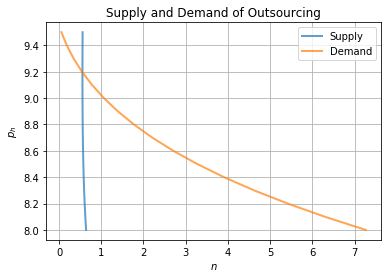

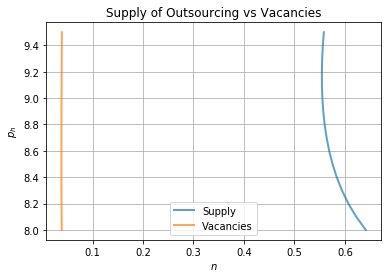

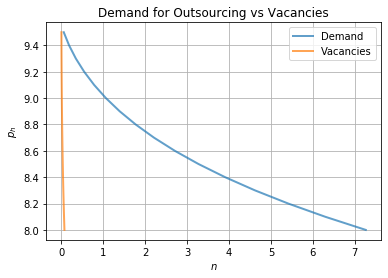

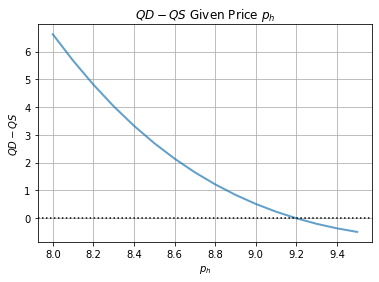

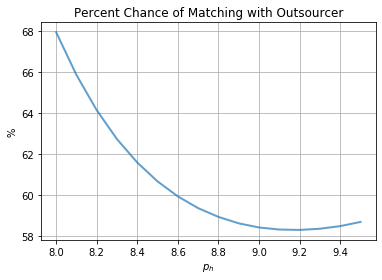

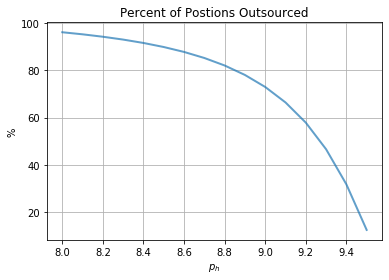

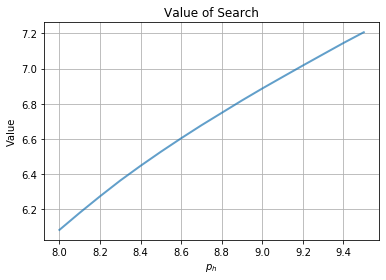

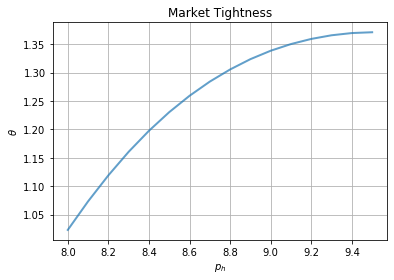

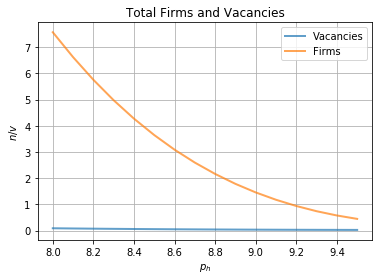

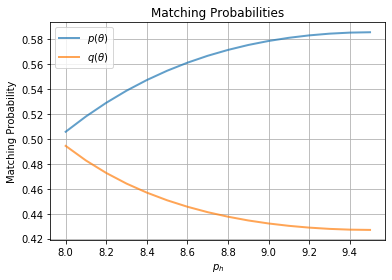

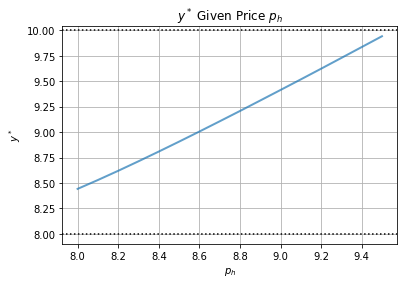

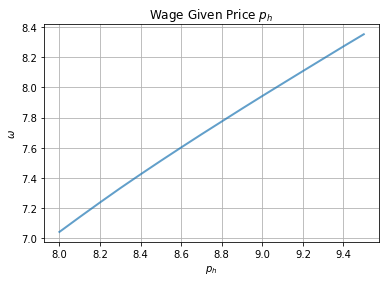

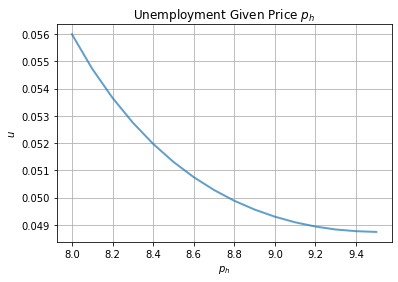

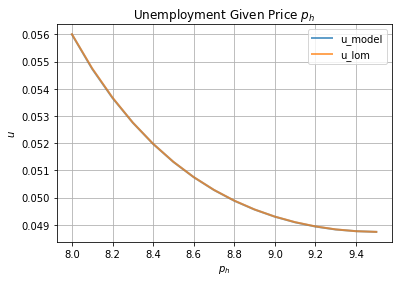

In [15]:
B = 0.95
r = 1 / B - 1
b = 0
delta = 0.03
eta = 0.5
eta_h = 0.5
# phi = 1
phi = 5e-1 
# y_min = 1
y_min = 5
y_max = 10
y_grid_size = 4000
gamma = 2
delta_hat = 0.01
gamma_h = 2
# k_grid = np.logspace(4, 5.5, y_grid_size)
k_grid = np.logspace(5, 7, y_grid_size)
k_h = 5e2
barg = 0

out = OutsourcerDiscrete(
    B, b, delta, delta_hat, eta, eta_h, phi, y_min, y_max, y_grid_size, gamma, gamma_h, k_grid, k_h, barg
)

tol_p = 1e-8
max_iter_p = 1e4
slow_p = 1e-3

p_h_min = y_min
# p_h_min = max(y_grid) * .9
p_h_max = y_max
p_h_grid_size = 20


graphing(out, p_h_min, p_h_max, p_h_grid_size, tol_p, max_iter_p, slow_p, save=False)

In [49]:
# Run top cell first
# Now solve planner's problem. Use FOC and lagrange multipliers. This one solves for lagrangians with everything else
# Use bisection again, this time on psi, the shadow cost of using outsourcing slots

def p_operator_factory(out):
    "Use a baseline case out and create a function to update Lagrange multipliers and solve planner's problem"
    
    r, b, delta, gamma, k_grid = out.r, out.b, out.delta, out.gamma, out.k_grid
    delta_hat, gamma_h, k_h = out.delta_hat, out.gamma_h, out.k_h
    y_grid, y_grid_size = out.y_grid, out.y_grid_size
    y_grid_max = max(y_grid)
    q, q_p, p = out.q, out.q_p, out.p 
    
    # Find quantity supplied and quantity demanded for outsourcing
    @njit()
    def find_QS_QD_p(v_grid, v_h, u, y_hat):
        
        theta = (np.sum(v_grid[y_grid < y_hat]) + v_h) / u
        # Supply of outsourcing are matched outsourcers, not outsourcer vacancies
        QS = v_h * q(theta) / delta
        # Demand for outsourcing are matched firms, not firm vacancies
        QD = np.sum(v_grid[y_grid >= y_hat]) / delta_hat
        return QS, QD
    

    # Find all lagrangians through iteration     
    # update v_grid, v_h, n_grid, n_h, y_hat, lam, mu, and rho
    @njit()
    def update_grids(v_grid, v_h, u, y_hat, lam, mu, rho, psi, slow, slow_l):   
                
        v_grid_new = np.empty(y_grid_size)
                 
        theta = (np.sum(v_grid[y_grid < y_hat]) + v_h) / u
        
        # lam is lagrangian for hiring firms
        # mu is lagrangian for outsourcing firms
        # rho is lagrangian for outsourcer
        # psi is lagrangian for outsourcing firms taking outsourcer slots (given)
        v_sum = np.sum(v_grid[y_grid < y_hat] * lam[y_grid < y_hat]) + v_h * rho
        lam_new = (y_grid - b + (theta * q_p(theta) * v_sum / u)) / (r + delta)
        mu_new = (y_grid - (1 + r) * psi) / (r + delta_hat)
        rho_new = (-b + (1 + r) * psi + (theta * q_p(theta) * v_sum / u)) / (r + delta)
        
        
        lam_new = lam_new * slow_l + lam * (1 - slow_l) 
        mu_new = mu_new * slow_l + mu * (1 - slow_l)
        rho_new = rho_new * slow_l + rho * (1 - slow_l)
        
        for j in range(2e2):
            
            theta = (np.sum(v_grid[y_grid < y_hat]) + v_h) / u

            v_sum = np.sum(v_grid[y_grid < y_hat] * lam_new[y_grid < y_hat]) + rho_new * v_h

            cost = lam_new[y_grid < y_hat] * q(theta) + (q_p(theta) / u) * v_sum           
            v_grid_new[y_grid < y_hat] = c_inv(cost, gamma, k_grid[y_grid < y_hat])

            v_grid_new[y_grid >= y_hat] = c_inv(mu_new[y_grid >= y_hat], gamma, k_grid[y_grid >= y_hat])

            cost_h = rho_new * q(theta) + (q_p(theta) / u) * v_sum
            v_h_new = c_h_inv(cost_h, gamma_h, k_h)

            n_grid_b = q(theta) * v_grid_new[y_grid < y_hat] / delta
            n_h = q(theta) * v_h_new / delta
            u_new = max(1 - np.sum(n_grid_b) - n_h, 1e-6)

            # Choose new y_hat by firm with closest marginal costs of outsourcing and hiring (comp near 0) 
            comp = lam_new * q(theta) + (q_p(theta) / u_new) * v_sum - mu_new
            ind_new = np.argmin(np.abs(comp))
            y_hat_new = y_grid[ind_new]

            v_grid = v_grid_new * slow + v_grid * (1 - slow) 
            v_h = v_h_new * slow + v_h * (1 - slow)
            u = u_new * slow + u * (1 - slow)
            y_hat = y_hat_new * slow + y_hat * (1 - slow)       
        
        return v_grid_new, v_h_new, u, y_hat_new, lam_new, mu_new, rho_new
    
    return update_grids, find_QS_QD_p

# Solve model given psi 
def solve_given_psi(out, psi, v_grid, v_h, u, y_hat, lam, mu, rho, tol, max_iter, slow, slow_l):
    
    update_grids, _ = p_operator_factory(out)
    
    # Set up initial loop parameters
    i = 0
    err = tol + 1    
    
    # Update v_grid, v_h, u, and y_hat each period
    while i < max_iter and err > tol:
        v_grid_new, v_h_new, u_new, y_hat_new, lam_new, mu_new, rho_new = update_grids(
            v_grid, v_h, u, y_hat, lam, mu, rho, psi, slow, slow_l)
        err_v = np.max(np.abs(v_grid_new - v_grid))
        err_v_h = np.abs(v_h_new - v_h)
        err_u = np.abs(u_new - u)
        err_y_hat = np.abs(y_hat_new - y_hat)
        err = max(err_v, err_v_h, err_u, err_y_hat)
        i += 1
        
        v_grid = v_grid_new 
        v_h = v_h_new       
        u = u_new
        y_hat = y_hat_new        
        lam = lam_new        
        mu = mu_new
        rho = rho_new
        
    return v_grid_new, v_h_new, u_new, y_hat_new, lam_new, mu_new, rho_new


# Find psi by bisection
def find_psi(
    out, guess, tol, max_iter, psi_low, psi_high, tol_p, max_iter_p, slow_p, slow_l, verbose=True, print_skip=100
):
    
    update_grids, find_QS_QD_p = p_operator_factory(out) 
    
    r, b, delta, delta_hat, y_grid = out.r, out.b, out.delta, out.delta_hat, out.y_grid
    
    # Set up loop parameters    
    err = tol + 1
    j = 0
    test = []
    
    # Find QD - QS for psi_low and psi_high, make sure they have opposite signs
    for psi in [psi_low, psi_high]:
        # Initial guesses
        v_grid, v_h, u, y_hat = guess    
        lam = (y_grid - b) / (r + delta)
        mu = (y_grid - (1 + r) * psi) / (r + delta_hat)
        rho = (-b + (1 + r) * psi) / (r + delta)
        
        v_grid, v_h, u, y_hat, lam, mu, rho = solve_given_psi(
            out, psi, v_grid, v_h, u, y_hat, lam, mu, rho, tol_p, max_iter_p, slow_p, slow_l)
        QS, QD = find_QS_QD_p(v_grid, v_h, u, y_hat)
        test.append(QD - QS)
        
        if verbose:
            print(f'Error for psi {psi} is {QD - QS}')
            
    if np.cumprod(test)[1] > 0:
        print('Test failed, both prices have positive/negative excess demand')
        return
    
    while err > tol and j < max_iter:
        psi = (psi_low + psi_high) / 2
        
        v_grid, v_h, u, y_hat, lam, mu, rho = solve_given_psi(
            out, psi, v_grid, v_h, u, y_hat, lam, mu, rho, tol_p, max_iter_p, slow_p, slow_l)
        QS, QD = find_QS_QD_p(v_grid, v_h, u, y_hat)
        err = np.abs(QD - QS)
        
        # If excess demand QD - QS > 0, set p_low = p_h, otherwise p_high = p_h
        if QD - QS > 0:
            psi_low = psi
        else:
            psi_high = psi
            
        if verbose and j % print_skip == 0:
            print(f'Error at iter {j} is {err}; psi is {psi}; QS is {QS}; QD is {QD}')
            
        j += 1
    
    if j < max_iter:
        print(f'Converged in {j} iterations, error is {err}; psi is {psi}; QS is {QS}; QD is {QD}')
    if j == max_iter:
        print(f'Failed to Converge. Error is {err}; psi is {psi}; QS is {QS}; QD is {QD}')
        
    return v_grid, v_h, u, y_hat


# Can check code against theoretical results by looking at spread and number of entrants
# For spread of entrants, 3 comparisons
# 1. Above y_hat, compare to y_max
# 2. Below y_hat, compare to y_max
# 3. Below y_hat, compare to y_hat (or largest y below y_hat)
# Graph results
# Keep in mind that spread_theory doesn't know that vacancies cannot be negative
def p_spread(out, v_grid, v_h, u, y_hat,
             save=False, folder=r'C:\Users\spspi\Dropbox\Documents\Outsourcing\Figures',
             file=r'\Outsourcers\planner_spread'):
    
    gamma, k_grid, eta, r, delta, delta_hat = out.gamma, out.k_grid, out.eta, out.r, out.delta, out.delta_hat
    gamma_h, k_h = out.gamma_h, out.k_h
    q, y_grid = out.q, out.y_grid
     
    theta = (np.sum(v_grid[y_grid < y_hat]) + v_h) / u 
    
    i_m = np.argmax(y_grid[v_grid > 0])    
    i_y = np.searchsorted(y_grid, y_hat)
    
    spread_theory_1 = (c(v_grid[i_m], gamma, k_grid[i_m]) - c(v_grid, gamma, k_grid)) * (r + delta_hat)
    
    spread_theory_2 = (c(v_grid[i_m], gamma, k_grid[i_m]) * (r + delta_hat) 
                       - (c(v_grid, gamma, k_grid) - c_h(v_h, gamma_h, k_h)) * (r + delta) / q(theta))
    
    spread_theory_3 = (c(v_grid[i_y], gamma, k_grid[i_y]) - c(v_grid, gamma, k_grid)) * (r + delta) / q(theta)
        
    spread_prod_y_max = y_grid[i_m] - y_grid
    spread_prod_y_max[v_grid == 0] = spread_theory_2[v_grid == 0]
    spread_prod_y_hat = y_grid[i_y] - y_grid
    spread_prod_y_hat[v_grid == 0] = spread_theory_3[v_grid == 0]
    
    dif_1 = spread_prod_y_max - spread_theory_1
    dif_2 = spread_prod_y_max - spread_theory_2
    dif_3 = spread_prod_y_hat - spread_theory_3
    
    
    fig, ax = plt.subplots()
    ax.plot(y_grid, spread_prod_y_max, lw=2, alpha=0.7, label='Productivity $y_{max}$')
    ax.plot(y_grid[:i_y], spread_prod_y_hat[:i_y], lw=2, alpha=0.7, label=r'Productivity $\hat{y}$')
    ax.plot(y_grid[i_y:], spread_theory_1[i_y:], lw=2, alpha=0.7, label='Theoretical 1')
    ax.plot(y_grid[:i_y], spread_theory_2[:i_y], lw=2, alpha=0.7, label='Theoretical 2')
    ax.plot(y_grid[:i_y], spread_theory_3[:i_y], lw=2, alpha=0.7, label='Theoretical 3')
    ax.set(xlabel='$y$', ylabel='Spread', title='Spread of Vacancies')
    ax.legend(loc='best')
    ax.grid()
    
    if save:
        fig.savefig(folder + file + '.pdf')
    else:
        plt.show()   
        
    fig, ax = plt.subplots()
    ax.plot(y_grid[i_y:], dif_1[i_y:], lw=2, alpha=0.7, label='Above')
    ax.plot(y_grid[:i_y], dif_2[:i_y], lw=2, alpha=0.7, label='Above-Below')
    ax.plot(y_grid[:i_y], dif_3[:i_y], lw=2, alpha=0.7, label='Below')
    ax.set(xlabel='$y$', ylabel='Spread', title='Difference in Spread of Vacancies')
    ax.legend(loc='best')
    ax.grid()
    ax.ticklabel_format(axis='y', style='sci', scilimits=(1,-1))
    
    if save:
        fig.savefig(folder + file + '_dif.pdf')
    else:
        plt.show() 
        
# For number of vacancies, look at above and below y_hat
def p_entry(out, v_grid, v_h, u, y_hat):
    
    b, gamma, k_grid, r, delta, delta_hat = out.b, out.gamma, out.k_grid, out.r, out.delta, out.delta_hat
    gamma_h, k_h = out.gamma_h, out.k_h
    q, q_p, p, y_grid = out.q, out.q_p, out.p, out.y_grid
      
    theta = (np.sum(v_grid[y_grid < y_hat]) + v_h) / u
    alpha = - theta * q_p(theta) / q(theta)
        
    entry_theory_a = np.sum(v_grid[y_grid >= y_hat] * (y_grid[y_grid >= y_hat] - b))
    entry_theory_b = np.sum(v_grid[y_grid < y_hat] * (y_grid[y_grid < y_hat] - b))
    
    i_m = np.argmax(y_grid[v_grid > 0])  
    
    # Find psi to estimate correct entry
    psi = (y_grid[i_m] - (r + delta_hat) * c(v_grid[i_m], gamma, k_grid[i_m])) / (1 + r)
    
    psi_min_b = (1 + r) * psi - b
    entry_code_a = ((r + delta_hat) * np.sum(v_grid[y_grid >= y_hat] * 
                                             c(v_grid[y_grid >= y_hat], gamma, k_grid[y_grid >= y_hat]))
                    + psi_min_b * np.sum(v_grid[y_grid >= y_hat]))
    entry_code_b = (((r + delta + theta * alpha * q(theta)) / ((1 - alpha) * q(theta))) 
                    * (np.sum(v_grid[y_grid < y_hat] * c(v_grid[y_grid < y_hat], gamma, k_grid[y_grid < y_hat])) 
                       + c_h(v_h, gamma_h, k_h) * v_h) - psi_min_b * v_h)
    
    print(f'Entry above from code gives {entry_code_a:.4f}; entry from theory gives {entry_theory_a:.4f}')
    print(f'Entry below from code gives {entry_code_b:.4f}; entry from theory gives {entry_theory_b:.4f}')
    
    # While doing this, also check if u is consistent with LOM
    u_t = delta / (delta + p(theta))  
    print(f'unemployment in model is {u:.4f}; according to LOM, should be {u_t:.4f}')
    # Probably related to whether p and q are < 1. Check these
    print(f'Employees match w/prob {p(theta):.2f}, employers match w/prob {q(theta):.2f}')   
    
    

Error for price 0 is 41.44049095300378
Error for price 11 is -0.7458068940233736
Error at iter 0 is 3.3727264804691917; price is 5.5; QS is 0.2269713183380515; QD is 3.599697798807243
Error at iter 10 is 0.0011783867564111872; price is 7.48193359375; QS is 0.30963943379259595; QD is 0.30846104703618477
Error at iter 20 is 0.0006386049911106251; price is 7.4803547859191895; QS is 0.3087648527400235; QD is 0.30940345773113415
Failed to Converge. Error is 0.0006385390736352026; price is 7.480355021543801; QS is 0.30876487486261045; QD is 0.30940341393624565
0.07987107222853201 0.47439154902630987 0.7259413461714184 0.3443804397125038
7.480355021543801 0.012759910004755445
Entry above from code gives 0.0286; entry from theory gives 0.0286
Entry below from code gives 0.1618; entry from theory gives 0.1626
unemployment in model is 0.0799; according to LOM, should be 0.0801
Employees match w/prob 0.34, employers match w/prob 0.73
Error for psi 5.480355021543801 is 1.95594951103352
Error for p

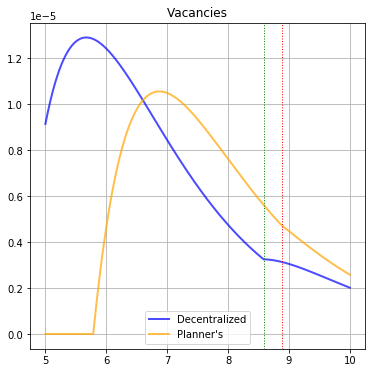

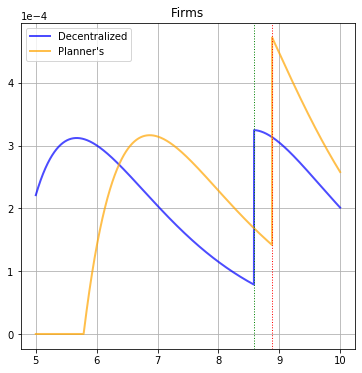

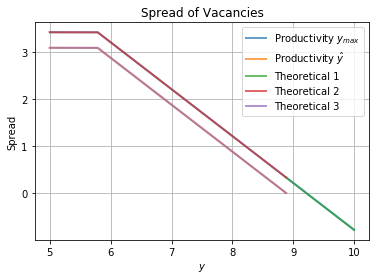

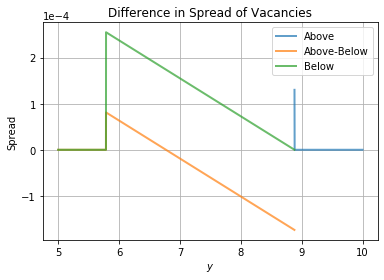

Entry above from code gives 0.0302; entry from theory gives 0.0302
Entry below from code gives 0.1413; entry from theory gives 0.1414
unemployment in model is 0.0975; according to LOM, should be 0.0975
Employees match w/prob 0.28, employers match w/prob 0.90


In [50]:
B = 0.95
r = 1 / B - 1
b = 0
delta = 0.03
eta = 0.5
eta_h = 0.5
# phi = 1
phi = 5e-1 
# y_min = 1
y_min = 5
y_max = 10
y_grid_size = 4000
gamma = 2
delta_hat = 0.01
gamma_h = 2
# k_grid = np.logspace(4, 5.5, y_grid_size)
k_grid = np.logspace(5, 7, y_grid_size)
k_h = 5e2
barg = 0

out = OutsourcerDiscrete(
    B, b, delta, delta_hat, eta, eta_h, phi, y_min, y_max, y_grid_size, gamma, gamma_h, k_grid, k_h, barg
)

q, y_grid = out.q, out.y_grid

tol = 1e-8
tol_p = 1e-8
max_iter = 30
max_iter_p = 1e4
print_skip = 10
slow_p = 1e-3
p_low = 0
p_high = y_max + 1

v_grid, v_h, u, y_hat, p_h = find_p(
    out, tol, max_iter, p_low, p_high, tol_p, max_iter_p, slow_p=slow_p, verbose=True, print_skip=print_skip
)

iterate, wages, get_y_hat, find_QS_QD = operator_factory(out)

w_grid, omega = wages(v_grid, v_h, u, y_hat, p_h)

theta = (np.sum(v_grid[out.y_grid < y_hat]) + v_h) / u

# print(theta * ((1 - pi) * np.sum(c(v_grid, gamma) * f_grid) + pi * c_h(v_h, gamma_h)))
print(u, theta, out.q(theta), out.p(theta))
print(p_h, v_h)
# print(np.sum(v_grid))

entry(out, v_grid, v_h, u, y_hat, p_h)

tol = 1e-8
tol_p = 1e-8
max_iter = 30
max_iter_p = 1e4
slow_p = 1e-2
slow_1 = 1e-1
ps = 5

psi_low = p_h - 2
psi_high = min(p_h + 2, y_max)

guess = [v_grid, v_h, u, y_hat]

v_grid_p, v_h_p, u_p, y_hat_p = find_psi(
    out, guess, tol, max_iter, psi_low, psi_high, tol_p, max_iter_p, slow_p, slow_l, verbose=True, print_skip=ps
)

print(f"Decentralized u is {u:.3f}, Planner's u is {u_p}")

theta = (np.sum(v_grid[y_grid < y_hat]) + v_h) / u
theta_p = (np.sum(v_grid_p[y_grid < y_hat_p]) + v_h_p) / u_p

n_grid, n_grid_p = np.empty(y_grid_size), np.empty(y_grid_size)

n_grid[y_grid >= y_hat] = v_grid[y_grid >= y_hat] / delta_hat
n_grid[y_grid < y_hat] = v_grid[y_grid < y_hat] * q(theta) / delta
n_grid_p[y_grid >= y_hat_p] = v_grid_p[y_grid >= y_hat_p] / delta_hat
n_grid_p[y_grid < y_hat_p] = v_grid_p[y_grid < y_hat_p] * q(theta_p) / delta


# Plot v_grids
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(out.y_grid, v_grid, lw=2, alpha=0.7, label="Decentralized", color='blue')
ax.plot(out.y_grid, v_grid_p, lw=2, alpha=0.7, label="Planner's", color='orange')
ax.axvline(x=y_hat, c='green', lw=1, linestyle=':')
ax.axvline(x=y_hat_p, c='red', lw=1, linestyle=':')
# ax.axhline(y=v_h, c='k', lw=2, linestyle='--')
ax.ticklabel_format(axis='y', style='sci', scilimits=(1,-1))
ax.grid()
ax.legend()
ax.set_title("Vacancies")

plt.show()

# Plot n_grids
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(out.y_grid, n_grid, lw=2, alpha=0.7, label="Decentralized", color='blue')
ax.plot(out.y_grid, n_grid_p, lw=2, alpha=0.7, label="Planner's", color='orange')
ax.axvline(x=y_hat, c='green', lw=1, linestyle=':')
ax.axvline(x=y_hat_p, c='red', lw=1, linestyle=':')
# ax.axhline(y=v_h, c='k', lw=2, linestyle='--')
ax.ticklabel_format(axis='y', style='sci', scilimits=(1,-1))
ax.grid()
ax.legend()
ax.set_title("Firms")

plt.show()

p_spread(out, v_grid_p, v_h_p, u_p, y_hat_p)

p_entry(out, v_grid_p, v_h_p, u_p, y_hat_p)

In [47]:
%debug

> <ipython-input-46-6deb15d03f96>(37)<module>()
     35 
     36 v_grid, v_h, u, y_hat, p_h = find_p(
---> 37     out, tol, max_iter, p_low, p_high, tol_p, max_iter_p, slow_p=slow_p, verbose=True, print_skip=print_skip
     38 )
     39 

ipdb> out
ipdb> tol
1e-08
ipdb> max_iter
30
ipdb> p_low
8.5
ipdb> p_high
9.5
ipdb> tol_p
1e-08
ipdb> top_p
*** NameError: name 'top_p' is not defined
ipdb> tol_p
1e-08
ipdb> max_iter_p
10000.0
ipdb> slow_p
0.001
ipdb> print_skip
10
ipdb> find_p
<function find_p at 0x000001B3A3357950>
ipdb> c


In [26]:
%debug

> <ipython-input-24-847f8141e6d3>(43)get_y_star_SD()
     41         choice = 1 * (J_H >= q(theta) * J)
     42         ind = np.searchsorted(choice, 0, side='right')
---> 43         return y_grid[ind]
     44 
     45     def iterate_SD(v_grid, v_h, u, y_star, p_h, slow=1):

ipdb> y_grid
array([ 1. ,  5.5, 10. ])
ipdb> choice
array([0, 0, 0])
ipdb> exit


In [4]:
# Run top cell first
# Now solve planner's problem. Use FOC and lagrange multipliers. This one solves for lagrangians separatley, 
# which is very slow/ probably uneccesary
# Use bisection again, this time on psi, the shadow cost of using outsourcing slots

def p_operator_factory(out):
    "Use a baseline case out and create a function to update Lagrange multipliers and solve planner's problem"
    
    r, b, delta, gamma, k = out.r, out.b, out.delta, out.gamma, out.k
    delta_hat, gamma_h, k_h = out.delta_hat, out.gamma_h, out.k_h
    y_grid, y_grid_size = out.y_grid, out.y_grid_size
    y_grid_max = max(y_grid)
    q, q_p, p = out.q, out.q_p, out.p 
    
    # Find quantity supplied and quantity demanded for outsourcing
    @njit()
    def find_QS_QD_p(v_grid, v_h, u, y_hat):
        
        theta = (np.sum(v_grid[y_grid < y_hat]) + v_h) / u
        # Supply of outsourcing are matched outsourcers, not outsourcer vacancies
        QS = v_h * q(theta) / delta
        # Demand for outsourcing are matched firms, not firm vacancies
        QD = np.sum(v_grid[y_grid >= y_hat]) / delta_hat
        return QS, QD
    
    # lam is lagrangian for hiring firms
    # mu is lagrangian for outsourcing firms
    # rho is lagrangian for outsourcer
    # psi is lagrangian for outsourcing firms taking outsourcer slots
    # Find all lagrangians through iteration 
    @njit()
    def find_lagrangians(v_grid, v_h, y_hat, u, lam, mu, rho, psi, tol, max_iter, slow): 
        
        i = 0
        err = tol + 1 
        theta = (np.sum(v_grid[y_grid < y_hat]) + v_h) / u

        while i < max_iter and err > tol:
            
            v_sum = np.sum(v_grid[y_grid < y_hat] * lam[y_grid < y_hat]) + v_h * rho
            lam_new = (y_grid - b + (theta * q_p(theta) * v_sum / u)) / (r + delta)
            mu_new = (y_grid - (1 + r) * psi) / (r + delta_hat)
            rho_new = (-b + (1 + r) * psi + (theta * q_p(theta) * v_sum / u)) / (r + delta)
            
            err_lam = np.max(np.abs(lam_new - lam))
            err_mu = np.max(np.abs(mu_new - mu))
            err_rho = np.abs(rho_new - rho)
            err = max(err_lam, err_mu, err_rho)
            
            i += 1
            
            lam = slow * lam_new + (1 - slow) * lam
            mu = slow * mu_new + (1 - slow) * mu
            rho = slow * rho_new + (1 - slow) * rho
            
        if i == max_iter:
            print('lagrangians failed to converge')
            print(err_lam, err_mu, err_rho)
        
        return lam_new, mu_new, rho_new
    
    # update v_grid, v_h, n_grid, n_h, and y_hat
    @njit()
    def update_grids(v_grid, v_h, u, y_hat, lam, mu, rho, psi, slow, tol_l, max_iter_l, slow_l=1e-4):

        lam_new, mu_new, rho_new = find_lagrangians(
            v_grid, v_h, y_hat, u, lam, mu, rho, psi, tol_l, max_iter_l, slow_l
        )
        
        v_grid_new = np.empty(y_grid_size)
        
        # Given a lagrangian, repeatedly update v_grid and u hopefully will be faster
        for j in range(2e1):
            
            theta = (np.sum(v_grid[y_grid < y_hat]) + v_h) / u
            
            v_sum = np.sum(v_grid[y_grid < y_hat] * lam_new[y_grid < y_hat]) + rho * v_h
            
            cost = lam_new[y_grid < y_hat] * q(theta) + (q_p(theta) / u) * v_sum           
            v_grid_new[y_grid < y_hat] = c_inv(cost, gamma, k)

            v_grid_new[y_grid >= y_hat] = c_inv(mu_new[y_grid >= y_hat], gamma, k)

            cost_h = rho_new * q(theta) + (q_p(theta) / u) * v_sum
            v_h_new = c_h_inv(cost_h, gamma_h, k_h)

            n_grid_b = q(theta) * v_grid_new[y_grid < y_hat] / delta
            n_h = q(theta) * v_h_new / delta
            u_new = max(1 - np.sum(n_grid_b) - n_h, 1e-6)
            
            # Choose new y_hat by firm with closest marginal costs of outsourcing and hiring (comp near 0) 
            comp = lam_new * q(theta) + (q_p(theta) / u_new) * v_sum - mu_new
            ind_new = np.argmin(np.abs(comp))
            y_hat_new = y_grid[ind_new]
            
            v_grid = v_grid_new * slow + v_grid * (1 - slow) 
            v_h = v_h_new * slow + v_h * (1 - slow)
            u = u_new * slow + u * (1 - slow)
            y_hat = y_hat_new * slow + y_hat * (1 - slow)       
        
        return v_grid_new, v_h_new, u, y_hat_new, lam_new, mu_new, rho_new
    
    return update_grids, find_lagrangians, find_QS_QD_p

# Solve model given psi 
def solve_given_psi(out, psi, v_grid, v_h, u, y_hat, lam, mu, rho,
                    tol, max_iter, slow, tol_l, max_iter_l, slow_l):
    
    update_grids, _, _ = p_operator_factory(out)
    
    # Set up initial loop parameters
    i = 0
    err = tol + 1    
    
    # Update v_grid, v_h, u, and y_hat each period
    while i < max_iter and err > tol:
        v_grid_new, v_h_new, u_new, y_hat_new, lam_new, mu_new, rho_new = update_grids(
            v_grid, v_h, u, y_hat, lam, mu, rho, psi, slow, tol_l, max_iter_l, slow_l)
        err_v = np.max(np.abs(v_grid_new - v_grid))
        err_v_h = np.abs(v_h_new - v_h)
        err_u = np.abs(u_new - u)
        err_y_hat = np.abs(y_hat_new - y_hat)
        err = max(err_v, err_v_h, err_u, err_y_hat)
        i += 1
        
#         v_grid = slow * v_grid_new + (1 - slow) * v_grid
#         v_h = slow * v_h_new + (1 - slow) * v_h        
#         u = slow * u_new + (1 - slow) * u
#         y_hat = slow * y_hat_new + (1 - slow) * y_hat        
#         lam = slow * lam_new + (1 - slow) * lam        
#         mu = slow * mu_new + (1 - slow) * mu
#         rho = slow * rho_new + (1 - slow) * rho 
        
    return v_grid_new, v_h_new, u_new, y_hat_new, lam_new, mu_new, rho_new


# Find psi by bisection
def find_psi(
    out, guess, tol, max_iter, psi_low, psi_high,
    tol_p, max_iter_p, slow_p, tol_l, max_iter_l, slow_l, verbose=True, print_skip=100
):
    
    update_grids, find_lagrangians, find_QS_QD_p = p_operator_factory(out) 
    
    r, b, delta, delta_hat, y_grid = out.r, out.b, out.delta, out.delta_hat, out.y_grid
    
    # Set up loop parameters    
    err = tol + 1
    j = 0
    test = []
    
    # Find QD - QS for psi_low and psi_high, make sure they have opposite signs
    for psi in [psi_low, psi_high]:
        # Initial guesses
        v_grid, v_h, u, y_hat = guess    
        lam = (y_grid - b) / (r + delta)
        mu = (y_grid - (1 + r) * psi) / (r + delta_hat)
        rho = (-b + (1 + r) * psi) / (r + delta)
        
        v_grid, v_h, u, y_hat, lam, mu, rho = solve_given_psi(
            out, psi, v_grid, v_h, u, y_hat, lam, mu, rho, tol, max_iter_p, slow_p, tol_l, max_iter_l, slow_l)
        QS, QD = find_QS_QD_p(v_grid, v_h, u, y_hat)
        test.append(QD - QS)
        
        if verbose:
            print(f'Error for psi {psi} is {QD - QS}')
            
    if np.cumprod(test)[1] > 0:
        print('Test failed, both prices have positive/negative excess demand')
        return
    
    while err > tol and j < max_iter:
        psi = (psi_low + psi_high) / 2
        
        v_grid, v_h, u, y_hat, lam, mu, rho = solve_given_psi(
            out, psi, v_grid, v_h, u, y_hat, lam, mu, rho, tol, max_iter_p, slow_p, tol_l, max_iter_l, slow_l)
        QS, QD = find_QS_QD_p(v_grid, v_h, u, y_hat)
        err = np.abs(QD - QS)
        
        # If excess demand QD - QS > 0, set p_low = p_h, otherwise p_high = p_h
        if QD - QS > 0:
            psi_low = psi
        else:
            psi_high = psi
            
        if verbose and j % print_skip == 0:
            print(f'Error at iter {j} is {err}; psi is {psi}; QS is {QS}; QD is {QD}')
            
        j += 1
    
    if j < max_iter:
        print(f'Converged in {j} iterations, error is {err}; psi is {psi}; QS is {QS}; QD is {QD}')
    if j == max_iter:
        print(f'Failed to Converge. Error is {err}; psi is {psi}; QS is {QS}; QD is {QD}')
        
    return v_grid, v_h, u, y_hat


# Can check code against theoretical results by looking at spread and number of entrants
# For spread of entrants, 3 comparisons
# 1. Above y_hat, compare to y_max
# 2. Below y_hat, compare to y_max
# 3. Below y_hat, compare to y_hat (or largest y below y_hat)
# Graph results
# Keep in mind that spread_theory doesn't know that vacancies cannot be negative
def p_spread(out, v_grid, v_h, u, y_hat,
             save=False, folder=r'C:\Users\spspi\Dropbox\Documents\Outsourcing\Figures',
             file='\Outsourcers\planner_spread'):
    
    gamma, k, eta, r, delta, delta_hat = out.gamma, out.k, out.eta, out.r, out.delta, out.delta_hat
    gamma_h, k_h = out.gamma_h, out.k_h
    q, y_grid = out.q, out.y_grid
     
    theta = (np.sum(v_grid[y_grid < y_hat]) + v_h) / u 
    
    ind = np.searchsorted(y_grid, y_hat)
    
    spread_theory_1 = (c(v_grid[-1], gamma, k) - c(v_grid, gamma, k)) * (r + delta_hat)
    
    spread_theory_2 = (c(v_grid[-1], gamma, k) * (r + delta_hat) 
                       - (c(v_grid, gamma, k) - c_h(v_h, gamma_h, k_h)) * (r + delta) / q(theta))
    
    spread_theory_3 = (c(v_grid[ind - 1], gamma, k) - c(v_grid, gamma, k)) * (r + delta) / q(theta)
        
    spread_prod_y_max = y_grid[-1] - y_grid
    spread_prod_y_max[v_grid == 0] = spread_theory_2[v_grid == 0]
    spread_prod_y_hat = y_grid[ind] - y_grid
    spread_prod_y_hat[v_grid == 0] = spread_theory_3[v_grid == 0]
    
    dif_1 = spread_prod_y_max - spread_theory_1
    dif_2 = spread_prod_y_max - spread_theory_2
    dif_3 = spread_prod_y_hat - spread_theory_3
    
    
    fig, ax = plt.subplots()
    ax.plot(y_grid, spread_prod_y_max, lw=2, alpha=0.7, label='Productivity $y_{max}$')
    ax.plot(y_grid[:ind], spread_prod_y_hat[:ind], lw=2, alpha=0.7, label=r'Productivity $\hat{y}$')
    ax.plot(y_grid[ind:], spread_theory_1[ind:], lw=2, alpha=0.7, label='Theoretical 1')
    ax.plot(y_grid[:ind], spread_theory_2[:ind], lw=2, alpha=0.7, label='Theoretical 2')
    ax.plot(y_grid[:ind], spread_theory_3[:ind], lw=2, alpha=0.7, label='Theoretical 3')
    ax.set(xlabel='$y$', ylabel='Spread', title='Spread of Vacancies')
    ax.legend(loc='best')
    ax.grid()
    
    if save:
        fig.savefig(folder + file + '.pdf')
    else:
        plt.show()   
        
    fig, ax = plt.subplots()
    ax.plot(y_grid[ind:], dif_1[ind:], lw=2, alpha=0.7, label='Above')
    ax.plot(y_grid[:ind], dif_2[:ind], lw=2, alpha=0.7, label='Above-Below')
    ax.plot(y_grid[:ind], dif_3[:ind], lw=2, alpha=0.7, label='Below')
    ax.set(xlabel='$y$', ylabel='Spread', title='Difference in Spread of Vacancies')
    ax.legend(loc='best')
    ax.grid()
    ax.ticklabel_format(axis='y', style='sci', scilimits=(1,-1))
    
    if save:
        fig.savefig(folder + file + '_dif.pdf')
    else:
        plt.show() 
        
# For number of vacancies, look at above and below y_hat
def p_entry(out, v_grid, v_h, u, y_hat):
    
    b, gamma, k, r, delta, delta_hat = out.b, out.gamma, out.k, out.r, out.delta, out.delta_hat
    gamma_h, k_h = out.gamma_h, out.k_h
    q, q_p, p, y_grid = out.q, out.q_p, out.p, out.y_grid
      
    theta = (np.sum(v_grid[y_grid < y_hat]) + v_h) / u
    alpha = - theta * q_p(theta) / q(theta)
        
    entry_theory_a = np.sum(v_grid[y_grid >= y_hat] * (y_grid[y_grid >= y_hat] - b))
    entry_theory_b = np.sum(v_grid[y_grid < y_hat] * (y_grid[y_grid < y_hat] - b))
    
    # Find psi to estimate correct entry
    psi = (y_grid[-1] - (r + delta_hat) * c(v_grid[-1], gamma, k)) / (1 + r)
    
    psi_min_b = (1 + r) * psi - b
    entry_code_a = ((r + delta_hat) * np.sum(v_grid[y_grid >= y_hat] * c(v_grid[y_grid >= y_hat], gamma, k))
                    + psi_min_b * np.sum(v_grid[y_grid >= y_hat]))
    entry_code_b = (((r + delta + theta * alpha * q(theta)) / ((1 - alpha) * q(theta))) 
                    * (np.sum(v_grid[y_grid < y_hat] * c(v_grid[y_grid < y_hat], gamma, k)) 
                       + c_h(v_h, gamma_h, k_h) * v_h) - psi_min_b * v_h)
    
    print(f'Entry above from code gives {entry_code_a:.4f}; entry from theory gives {entry_theory_a:.4f}')
    print(f'Entry below from code gives {entry_code_b:.4f}; entry from theory gives {entry_theory_b:.4f}')
    
    # While doing this, also check if u is consistent with LOM
    u_t = delta / (delta + p(theta))  
    print(f'unemployment in model is {u:.4f}; according to LOM, should be {u_t:.4f}')
    # Probably related to whether p and q are < 1. Check these
    print(f'Employees match w/prob {p(theta):.2f}, employers match w/prob {q(theta):.2f}')
    

In [3]:
# Run top cell first
# Use these "remember" figures so don't have to rerun while testing program
B = 0.95
r = 1 / B - 1
b = 0
delta = 0.03
eta = 0.5
# phi = 1
phi = 2e-1 
# y_min = 1
y_min = 8
y_max = 10
y_grid_size = 4000
gamma = 2
delta_hat = 0.01
gamma_h = 5
k = 2e6
k_h = 2e6

out = OutsourcerDiscrete(B, b, delta, delta_hat, eta, phi, y_min, y_max, y_grid_size, gamma, gamma_h, k, k_h)

v_grid_r, v_h_r, u_r, y_hat_r, p_h_r = find_p(
    out, tol=1e-4, max_iter=5e2, tol_p=1e-4, max_iter_p=1e4, verbose=True, print_skip=10, slow=1e-1, slow_p=1e-3)

Error at iter 1 is 0.5211003308943031; price is 9.0; QS is 0.5211003308943031; QD is 0.0
Error at iter 10 is 0.2828620577007762; price is 8.597650515773179; QS is 0.532303868576652; QD is 0.2494418108758758
Error at iter 11 is 0.25360374088145243; price is 8.5693643100031; QS is 0.5338460422972305; QD is 0.2802423014157781
Error at iter 20 is 0.08735616123634338; price is 8.419319561115879; QS is 0.5423599581639853; QD is 0.4550037969276419
Error at iter 21 is 0.07703752855081153; price is 8.410583944992245; QS is 0.542876735227759; QD is 0.4658392066769475
Error at iter 30 is 0.02481991370498804; price is 8.36640877921924; QS is 0.5454685308091545; QD is 0.5206486171041664
Error at iter 31 is 0.021717754050943117; price is 8.363926787848742; QS is 0.5456225693280998; QD is 0.5239048152771567
Error at iter 40 is 0.006625997825314589; price is 8.351631844674488; QS is 0.5463759830360303; QD is 0.5397499852107157
Error at iter 41 is 0.005934717917089438; price is 8.350969244891957; QS is

In [10]:
# Run top cell first
# Now solve planner's problem. Use FOC and lagrange multipliers
# Problem's above updating psi. Try raising and lowering it based on QD and QS as with price

def p_operator_factory(out):
    "Use a baseline case out and create a function to update Lagrange multipliers and solve planner's problem"
    
    B, r, b, delta, eta, gamma, k = out.B, out.r, out.b, out.delta, out.eta, out.gamma, out.k
    delta_hat, gamma_h, k_h = out.delta_hat, out.gamma_h, out.k_h
    y_grid, y_grid_size = out.y_grid, out.y_grid_size
    y_grid_max = max(y_grid)
    q, q_p, p = out.q, out.q_p, out.p
    
    # Use y_hat to find it's closest value on y_grid
    @njit()
    def find_y_hat(y_hat):
        ind = np.searchsorted(y_grid, y_hat, side='left')
        # If always above, set equal to top
        ind = np.int64(min(ind, y_grid_size))
        return y_grid[ind]    

    # Use v_grid, v_h, n_grid, n_h, and y_hat to find u and theta 
    @njit()
    def p_get_dist(v_grid, v_h, n_grid, n_h, y_hat):
        u = max(1 - np.sum(n_grid[y_grid < y_hat]) - n_h, 1e-6)
        theta = max(np.sum(v_grid[y_grid < y_hat]) + v_h, 1e-6) / u
        return u, theta
    
    # lam is lagrangian for hiring firms
    # mu is lagrangian for outsourcing firms
    # rho is lagrangian for outsourcer
    # psi is lagrangian for outsourcing firms less than outsourcer
    # Find all lagrangians through iteration 
    @njit()
    def find_lagrangians(v_grid, v_h, y_hat, u, theta, lam, mu, rho, psi, tol_l=1e-4, max_iter_l=1000, slow_l=1e-4):       
        i = 0
        err = tol_l + 1
        
#         lam = np.ones(y_grid_size)
#         mu = np.ones(y_grid_size)
#         rho = np.float32(1)
#         psi = np.float32(1)

#         # Another way to calculate psi
#         psi = (y_grid[-1] + (r + delta_hat) * c(v_grid[-1], gamma, k)) / (1 + r)

        while i < max_iter_l and err > tol_l:
            
            y_hat = find_y_hat(y_hat)
            
            v_sum = np.sum(v_grid[y_grid < y_hat] * lam[y_grid < y_hat]) + v_h * rho
            lam_new = (y_grid - b + (theta * q_p(theta) * v_sum / u)) / (r + delta)
            mu_new = (y_grid - (1 + r) * psi) / (r + delta_hat)
            rho_new = (-b + (1 + r) * psi + (theta * q_p(theta) * v_sum / u)) / (r + delta)
            
            err_lam = np.max(np.abs(lam_new - lam))
            err_mu = np.max(np.abs(mu_new - mu))
            err_rho = np.abs(rho_new - rho)
            err = max(err_lam, err_mu, err_rho)
            
            i += 1
            
            lam = slow_l * lam_new + (1 - slow_l) * lam
            mu = slow_l * mu_new + (1 - slow_l) * mu
            rho = slow_l * rho_new + (1 - slow_l) * rho
            
        if i == max_iter_l:
            print('lagrangians failed to converge')
            print(err_lam, err_mu, err_rho)
        
        return lam_new, mu_new, rho_new
    
    # update v_grid, v_h, n_grid, n_h, and y_hat
    @njit()
    def update_grids(v_grid, v_h, n_grid, n_h, y_hat, lam, mu, rho, psi, tol_l, max_iter_l, slow=1, slow_l=1e-4):
        
        y_hat = find_y_hat(y_hat)
        
        u, theta = p_get_dist(v_grid, v_h, n_grid, n_h, y_hat)

        lam_new, mu_new, rho_new = find_lagrangians(
            v_grid, v_h, y_hat, u, theta, lam, mu, rho, psi, tol_l, max_iter_l, slow_l
        )
        
        v_grid_new, n_grid_new = np.empty(y_grid_size), np.empty(y_grid_size)
        
        # Given a lagrangian, repeatedly update v_grid and n_grid hopefully will be faster
        for j in range(1e3):
            
            v_sum = np.sum(v_grid[y_grid < y_hat] * lam_new[y_grid < y_hat]) + rho * v_h
            
            cost = lam_new[y_grid < y_hat] * q(theta) + (q_p(theta) / u) * v_sum           
            v_grid_new[y_grid < y_hat] = c_inv(cost, gamma, k)

            v_grid_new[y_grid >= y_hat] = c_inv(mu_new[y_grid >= y_hat], gamma, k)

            cost_h = rho_new * q(theta) + (q_p(theta) / u) * v_sum
            v_h_new = c_h_inv(cost_h, gamma_h, k_h)

            n_grid_new[y_grid < y_hat] = q(theta) * v_grid_new[y_grid < y_hat] / delta

            n_grid_new[y_grid >= y_hat] = v_grid_new[y_grid >= y_hat] / delta_hat

            n_h_new = q(theta) * v_h_new / delta
            
            comp = lam_new * q(theta) + (q_p(theta) / u) * v_sum- mu_new
            ind_new = np.argmin(np.abs(comp))
            y_hat_new = y_grid[ind_new]
            
            v_grid = v_grid_new * slow + v_grid * (1 - slow) 
            v_h = v_h_new * slow + v_h * (1 - slow)
            n_grid = n_grid_new * slow + n_grid * (1 - slow)
            n_h = n_h_new * slow + n_h * (1 - slow)
            y_hat = y_hat_new * slow + y_hat * (1 - slow)
            
            y_hat = find_y_hat(y_hat)        
            u, theta = p_get_dist(v_grid, v_h, n_grid, n_h, y_hat)
        
        return v_grid_new, v_h_new, n_grid_new, n_h_new, y_hat_new, lam_new, mu_new, rho_new
    
    return update_grids, find_y_hat, p_get_dist, find_lagrangians

# Solve model
def solve_p_model(out, guess, tol_l=1e-4, tol=1e-4, max_iter_l=1e3, max_iter=1e4, verbose=True, print_skip=1e3,
                  slow=1, slow_l=1e-2, slow_p=1):   

    update_grids, _, _, find_lagrangians = p_operator_factory(out)

    y_grid, r, b, delta, delta_hat = out.y_grid, out.r, out.b, out.delta, out.delta_hat
    gamma, gamma_h, k, k_h = out.gamma, out.gamma_h, out.k, out.k_h 
    q = out.q
    
    # Set up initial guesses and loop parameters

    v_grid, v_h, u, y_hat = guess
    
    theta = (np.sum(v_grid[y_grid < y_hat]) + v_h) / u
    n_grid = (q(theta) * v_grid) / delta
    n_grid[y_grid > y_hat] = v_grid[y_grid > y_hat] / delta_hat
    n_h = (q(theta) * v_h) / delta
    
    # Carry around lagrangian to make re-estimating faster
    lam = (y_grid - b) / (r + delta)
    psi = (y_grid[-1] - (r + delta_hat) * c(v_grid[-1], gamma, k)) / (1 + r)
    mu = (y_grid - (1 + r) * psi) / (r + delta_hat)
    rho = (-b + (1 + r) * psi) / (r + delta)
    
    i = 0
    err = tol + 1 
    
    # Update v_grid, v_h, n_grid, n_h, and lagrangian each period
    while i < max_iter and err > tol:
        v_grid_new, v_h_new, n_grid_new, n_h_new, y_hat_new, lam_new, mu_new, rho_new = update_grids(
            v_grid, v_h, n_grid, n_h, y_hat, lam, mu, rho, psi, tol_l, max_iter_l, slow, slow_l)
        
        o_demand = np.sum(n_grid_new[out.y_grid > y_hat_new])
        o_supply = n_h_new
        err_o = o_demand - o_supply
        psi += err_o * slow_p
        err_v = np.max(np.abs(v_grid_new - v_grid))
        err_n = np.max(np.abs(n_grid_new - n_grid))
        err_v_h = np.abs(v_h_new - v_h)
        err_n_h = np.abs(n_h_new - n_h)
        err_y_hat = np.abs(y_hat_new - y_hat)
        err = max(err_v, err_n, err_v_h, err_n_h, err_y_hat, np.abs(err_o))
        i += 1
        
        if verbose and i % print_skip == 0:
            print(f'Error at iter {i} is {err}')
            print(y_hat_new, v_grid_new[-1])
            
        if verbose and i % print_skip == 1:
            print(f'Error at iter {i} is {err}')
            print(y_hat_new, v_grid_new[-1])
            if v_grid_new[-1] == 0:
                print(lam_new[-1], mu_new[-1], rho_new, psi)
        
        if verbose and i >= 0 and i <= 5:
            print(f'Error at iter {i} is {err}')
            print(y_hat_new, v_grid_new[-1])
        
        v_grid = v_grid_new * slow + v_grid * (1 - slow)
        v_h = v_h_new * slow + v_h * (1 - slow)
        n_grid = n_grid_new * slow + n_grid * (1 - slow)
        n_h = n_h_new * slow + n_h * (1 - slow)
        y_hat = y_hat_new * slow + y_hat * (1 - slow)
        lam = lam_new * slow + lam * (1 - slow)
        mu = mu_new * slow + mu * (1 - slow)
        rho = rho_new * slow + rho * (1 - slow)
#         psi = (y_grid[-1] - (r + delta_hat) * c(v_grid[-1], gamma, k)) / (1 + r)
        
    if i == max_iter:
        print("Failed to Converge")
        
    if verbose and i < max_iter:
        print(f'Converged in {i} iterations')
    
    return v_grid_new, v_h_new, n_grid_new, n_h_new, y_hat_new 

# Can check code against theoretical results by looking at spread and number of entrants
# For spread of entrants, 3 comparisons
# 1. Above y_hat, compare to y_max
# 2. Below y_hat, compare to y_max
# 3. Below y_hat, compare to y_hat (or largest y below y_hat)
# Graph results
# Keep in mind that spread_theory doesn't know that vacancies cannot be negative
def spread_p(out, v_grid, v_h, n_grid, n_h, y_hat,
             save=False, folder=r'C:\Users\spspi\Dropbox\Documents\Outsourcing\Figures', file='\Outsourcers\Planner_Spread'):
    
    gamma, k, eta, r, delta, delta_hat = out.gamma, out.k, out.eta, out.r, out.delta, out.delta_hat
    gamma_h, k_h = out.gamma_h, out.k_h
    q, y_grid = out.q, out.y_grid
     
    theta = (np.sum(v_grid[y_grid < y_hat]) + v_h) / (1 - np.sum(n_grid[y_grid < y_hat]) - n_h)
    
    ind = np.searchsorted(y_grid, y_hat)
    
    spread_theory_1 = (c(v_grid[-1], gamma, k) - c(v_grid, gamma, k)) * (r + delta_hat)
    
    spread_theory_2 = (c(v_grid[-1], gamma, k) * (r + delta_hat) 
                       - (c(v_grid, gamma, k) - c_h(v_h, gamma_h, k_h)) * (r + delta) / q(theta))
    
    spread_theory_3 = (c(v_grid[ind - 1], gamma, k) - c(v_grid, gamma, k)) * (r + delta) / q(theta)
        
    spread_prod_y_max = y_grid[-1] - y_grid
    spread_prod_y_max[v_grid == 0] = spread_theory_2[v_grid == 0]
    spread_prod_y_hat = y_grid[ind] - y_grid
    spread_prod_y_hat[v_grid == 0] = spread_theory_3[v_grid == 0]
    
    dif_1 = spread_prod_y_max - spread_theory_1
    dif_2 = spread_prod_y_max - spread_theory_2
    dif_3 = spread_prod_y_hat - spread_theory_3
    
    fig, ax = plt.subplots()
    ax.plot(y_grid, spread_prod_y_max, lw=2, alpha=0.7, label='Productivity $y_{max}$')
    ax.plot(y_grid[:ind], spread_prod_y_hat[:ind], lw=2, alpha=0.7, label=r'Productivity $\hat{y}$')
    ax.plot(y_grid[ind:], spread_theory_1[ind:], lw=2, alpha=0.7, label='Theoretical 1')
    ax.plot(y_grid[:ind], spread_theory_2[:ind], lw=2, alpha=0.7, label='Theoretical 2')
    ax.plot(y_grid[:ind], spread_theory_3[:ind], lw=2, alpha=0.7, label='Theoretical 3')
    ax.set(xlabel='$y$', ylabel='Spread', title='Spread of Vacancies')
    ax.legend(loc='best')
    ax.grid()
    
    if save:
        fig.savefig(folder + file)
    else:
        plt.show()   
        
    fig, ax = plt.subplots()
    ax.plot(y_grid[ind:], dif_1[ind:], lw=2, alpha=0.7, label='Above')
    ax.plot(y_grid[:ind], dif_2[:ind], lw=2, alpha=0.7, label='Above-Below')
    ax.plot(y_grid[:ind], dif_3[:ind], lw=2, alpha=0.7, label='Below')
    ax.set(xlabel='$y$', ylabel='Spread', title='Difference in Spread of Vacancies')
    ax.legend(loc='best')
    ax.grid()
    ax.ticklabel_format(axis='y', style='sci', scilimits=(1,-1))
    
    if save:
        fig.savefig(folder + file + '_dif')
    else:
        plt.show() 
        
# For number of vacancies, look at above and below y_hat
def entry_p(out, v_grid, v_h, n_grid, n_h, y_hat):
    
    b, gamma, k, eta, r, delta, delta_hat = out.b, out.gamma, out.k, out.eta, out.r, out.delta, out.delta_hat
    gamma_h, k_h = out.gamma_h, out.k_h
    q, q_p, p, y_grid = out.q, out.q_p, out.p, out.y_grid
     
    u = 1 - np.sum(n_grid[y_grid < y_hat]) - n_h    
    theta = (np.sum(v_grid[y_grid < y_hat]) + v_h) / u
    alpha = - theta * q_p(theta) / q(theta)
    
    ind = np.searchsorted(y_grid, y_hat)
    
    entry_theory_a = np.sum(v_grid[ind:] * (y_grid[ind:] - b))
    entry_theory_b = np.sum(v_grid[:ind] * (y_grid[:ind] - b))
    
    
    # Find psi to estimate correct entry
    psi = (y_grid[-1] - (r + delta_hat) * c(v_grid[-1], gamma, k)) / (1 + r)
    
    psi_min_b = (1 + r) * psi - b
    entry_code_a = ((r + delta_hat) * np.sum(v_grid[ind:] * c(v_grid[ind:], gamma, k))
                    + psi_min_b * np.sum(v_grid[ind:]))
    entry_code_b = (((r + delta + theta * alpha * q(theta)) / ((1 - alpha) * q(theta))) 
                    * (np.sum(v_grid[:ind] * c(v_grid[:ind], gamma, k)) + c_h(v_h, gamma_h, k_h) * v_h)
                    - psi_min_b * v_h)
    
    print(f'Entry above from code gives {entry_code_a:.4f}; entry from theory gives {entry_theory_a:.4f}')
    print(f'Entry below from code gives {entry_code_b:.4f}; entry from theory gives {entry_theory_b:.4f}')
    
    # While doing this, also check if u is consistent with LOM
    u_t = delta / (delta + p(theta))  
    print(f'unemployment in model is {u:.4f}; according to LOM, should be {u_t:.4f}')
    # Probably related to whether p and q are < 1. Check these
    print(f'Employees match w/prob {p(theta):.2f}, employers match w/prob {q(theta):.2f}')
    
    # Also check if outsourcing firms equals outsourcer firms
    print(f'Number of outsourcing firms is {np.sum(n_grid[ind:]):.5f}, number of outsourcer firms is {n_h:.5f}')

In [ ]:
B = 0.95
r = 1 / B - 1
delta = 0.03
eta = 0.5
phi = 5e-1 
y_min = 8
y_max = 10
b = y_min * .4
y_grid_size = 4000
gamma = 2
delta_hat = 0.01
gamma_h = 5
k = 5e5
k_h = 5e5

out = OutsourcerDiscrete(B, b, delta, delta_hat, eta, phi, y_min, y_max, y_grid_size, gamma, gamma_h, k, k_h)

tol = 1e-6
max_iter = 1e4
tol_p = 1e-8
max_iter_p = 1e4
print_skip = 50
slow = 5e-2
slow_p = 1e-3

v_grid, v_h, u, y_hat, p_h = find_p(
    out, tol, max_iter, tol_p, max_iter_p, verbose=True, print_skip=print_skip, slow=slow, slow_p=slow_p)

theta = (np.sum(v_grid[out.y_grid < y_hat]) + v_h) / u
n_grid = np.zeros(y_grid_size)
n_grid[out.y_grid < y_hat] = out.q(theta) * v_grid[out.y_grid < y_hat] / delta
n_grid[out.y_grid >= y_hat] =  v_grid[out.y_grid >= y_hat] / delta_hat

tol = 1e-4
max_iter = 1e3
tol_l = 1e-6
max_iter_l = 1e6
ps = 5e1
slow = 1e-2
slow_l = 5e-3
slow_p = 1e-2

guess = [v_grid, v_h, u, y_hat]

v_grid_p, v_h_p, n_grid_p, n_h_p, y_hat_p = solve_p_model(
    out, guess=guess, tol_l=tol_l, tol=tol, max_iter_l=max_iter_l, max_iter=max_iter,
    verbose=True, print_skip=ps, slow=slow, slow_l=slow_l, slow_p=slow_p)

u_p = 1 - np.sum(n_grid_p[out.y_grid < y_hat_p]) - n_h_p
print(f"Decentralized u is {u:.3f}, Planner's u is {u_p}")

# Plot v_grids
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(out.y_grid, v_grid, lw=2, alpha=0.7, label="Decentralized", color='blue')
ax.plot(out.y_grid, v_grid_p, lw=2, alpha=0.7, label="Planner's", color='orange')
ax.axvline(x=y_hat, c='green', lw=1, linestyle=':')
ax.axvline(x=y_hat_p, c='red', lw=1, linestyle=':')
# ax.axhline(y=v_h, c='k', lw=2, linestyle='--')
ax.ticklabel_format(axis='y', style='sci', scilimits=(1,-1))
ax.grid()
ax.legend()
ax.set_title("Vacancies")

plt.show()

# Plot n_grids
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(out.y_grid, n_grid, lw=2, alpha=0.7, label="Decentralized", color='blue')
ax.plot(out.y_grid, n_grid_p, lw=2, alpha=0.7, label="Planner's", color='orange')
ax.axvline(x=y_hat, c='green', lw=1, linestyle=':')
ax.axvline(x=y_hat_p, c='red', lw=1, linestyle=':')
# ax.axhline(y=v_h, c='k', lw=2, linestyle='--')
ax.ticklabel_format(axis='y', style='sci', scilimits=(1,-1))
ax.grid()
ax.legend()
ax.set_title("Firms")

plt.show()

spread_p(out, v_grid_p, v_h_p, n_grid_p, n_h_p, y_hat_p)

entry_p(out, v_grid_p, v_h_p, n_grid_p, n_h_p, y_hat_p)

Error at iter 1 is 0.6037109074045659; price is 9.0; QS is 0.7075706104538921; QD is 1.311281517858458
Error at iter 50 is 0.0009062696908082035; price is 9.214892243927661; QS is 0.6956277253749645; QD is 0.6965339950657727
Error at iter 51 is 0.0008503326515811871; price is 9.2149375574122; QS is 0.6956314985969885; QD is 0.6964818312485697
Error at iter 100 is 6.8403860379318004e-06; price is 9.215124887340362; QS is 0.6955811127617916; QD is 0.6955879531478295
Error at iter 101 is 6.310260661335221e-06; price is 9.215125229359664; QS is 0.6955812497086767; QD is 0.6955875599693381
Error at iter 150 is 3.3840904967163965e-07; price is 9.215130161595335; QS is 0.695581551561635; QD is 0.6955818899706847
Error at iter 151 is 2.0898917019174235e-07; price is 9.215130178515787; QS is 0.6955816615301038; QD is 0.695581870519274
Converged in 175 iterations
Error at iter 175 is 1.5984381596112485e-09; price is 9.215130346397546; QS is 0.6955816759273524; QD is 0.6955816775257906
Error at i

In [ ]:
%debug

> <ipython-input-24-6eb106644707>(45)find_lagrangians()
     43         while i < max_iter_l and err > tol_l:
     44             lam_new = ((y_grid - b
---> 45                         + (theta * q_p(theta) / u) * (np.sum(v_grid[:ind] * lam[:ind]) + v_h * rho))
     46                        / (r + delta))
     47             mu_new = (y_grid - (1 + r) * psi) / (r + delta_hat)

ipdb> ind
9.0
ipdb> v_grid[:ind]
*** TypeError: slice indices must be integers or None or have an __index__ method
ipdb> v_grid
array([5.00000000e-07, 5.00031258e-07, 5.00062516e-07, ...,
       6.24937484e-07, 6.24968742e-07, 6.25000000e-07])


In [1]:
# Older version of the code
# Add outsourcers, who can sell labor to firms in frictionless markets

import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe
from numba import jit, njit, prange, vectorize
from scipy import optimize
from IPython.core.debugger import set_trace

# Want to vectorize cost of vacancy, marginal cost of vacancy, and inverse marginal cost of vacancy
@vectorize
def C(v, gamma=2, k=1):
    return k * v**gamma

@vectorize
def c(v, gamma=2, k=1):
    return k * gamma * v**(gamma - 1)
     
@vectorize
def c_inv(c, gamma=2, k=1):
    if c > 0:
        return (c / gamma / k)**(1 / (gamma - 1))
    else:
        return 0

# Do the same for outsourcers, who have C^H(v) = v**gamma_h
@vectorize
def C_h(v, gamma_h=1.5, k_h=1):
    return k_h * v**gamma_h

@vectorize
def c_h(v, gamma_h=1.5, k_h=1):
    if v > 0:
        return k_h * gamma_h * v**(gamma_h - 1)
    else:
        return 0
     
@vectorize
def c_h_inv(c, gamma_h=1.5, k_h=1):
    if c > 0:
        return (c / gamma_h / k_h)**(1 / (gamma_h - 1))
    else:
        return 0
    
# Set up the baseline environment, starting with a discrete model
class OutsourcerDiscrete:
    """
    B is discount rate beta
    r is interest rate defined by beta
    b is home production
    delta is job loss rate
    delta_hat is firm destruction rate <= delta
    eta is worker bargaining power    
    phi is effectiveness of matching function
    q is firm's matching function, worker's is p=theta*q(theta)
    y_min, y_max, y_grid_size determine productivity grid
    gamma is steepness of marginal cost
    gamma_h is steepness of marginal cost for outsourcer
    q is matching function of firms
    p is matching function of workers
    
    q_p is derivative of firm's matching function for Planner's
    p_p is derivative of worker's matching function for Planner's
    """
    def __init__(self, B, b, delta, delta_hat, eta, phi, y_min, y_max, y_grid_size, gamma, gamma_h, k, k_h):
        
        self.B, self.b, self.delta, self.eta, self.gamma, self.k = B, b, delta, eta, gamma, k
        self.delta_hat, self.gamma_h, self.k_h = delta_hat, gamma_h, k_h 
        self.r = 1 / B - 1
        
        self.y_grid = np.linspace(y_min, y_max, y_grid_size)
        self.y_grid_size = y_grid_size        
        
        self.q = njit(lambda x: min(phi * x**(-1 / 2), 1))
        self.p = njit(lambda x: min(phi * x**(1 / 2), 1))
        self.q_p = njit(lambda x: -phi / 2 * x**(-3 / 2)) 
        self.p_p = njit(lambda x: phi / 2 * x**(1 / 2))
        
# Try to find eqbm by chosing p_h and comparing QD to QS. Simialr method to one used above

# First set up iteration
def operator_factory(out):
    
    B, r, b, delta, eta, gamma, k = out.B, out.r, out.b, out.delta, out.eta, out.gamma, out.k
    delta_hat, gamma_h, k_h = out.delta_hat, out.gamma_h, out.k_h
    y_grid, y_grid_size = out.y_grid, out.y_grid_size
    y_grid_max = max(y_grid)
    q, p = out.q, out.p
    
    # Use v_grid, u, v_h, and y_hat to find pi, theta and f_grid (make sure v not 0)
    @njit()
    def get_dist(v_grid, v_h, u, y_hat):
        v = max(np.sum(v_grid[y_grid < y_hat]), 1e-6)    
        # Outsourcing firms not in f_grid
        f_grid = np.minimum(v_grid / v, y_grid < y_hat)
        theta = (v + v_h) / u
        pi = v_h / (v + v_h)
        
        return theta, f_grid, pi    
    
    # Find wages for each postion
    @njit()
    def prices(v_grid, v_h, p_h, theta, f_grid, pi):
        # Useful to define a value of search 
        val_search = theta * ((1 - pi) * np.sum(c(v_grid, gamma, k) * f_grid) + pi * c_h(v_h, gamma_h, k_h))
#         # For some reason, val_seach likes to sometimes return vectors, change this
#         try:
#             val_search = val_search[0]
#         except:
#             val_search = val_search
        w_grid = b + eta * (y_grid - b + val_search)
        omega = b + eta * (p_h - b + val_search)
                        
        return w_grid, omega 
    
    # Find y_hat using prices
    @njit()
    def get_y_hat(theta, w_grid, p_h):
        J = (y_grid - w_grid) / (r + delta)
        J_H = (y_grid - p_h) / (r + delta_hat)
        choice = 1 * (J_H >= q(theta) * J) * (J_H > 0)
        ind = np.searchsorted(choice, 0, side='right')
        # If y_hat > y_max, return y_max + 1
        if ind < y_grid_size:
            y_hat = y_grid[ind]
        else:
            y_hat = y_grid_max + 1
        return y_hat
    
    # Find quantity supplied and quantity demanded for outsourcing
    @njit()
    def find_QS_QD(v_grid, v_h, u, y_hat):
        # Find st st supply and demand of outsourcing
        theta, f_grid, pi = get_dist(v_grid, v_h, u, y_hat)        
        # Supply of outsourcing are matched outsourcers, not outsourcer vacancies
        QS = v_h * q(theta) / delta
        # Demand for outsourcing are matched firms, not firm vacancies
        QD = np.sum(v_grid[y_grid >= y_hat]) / delta_hat
        return QS, QD
    
    @njit()
    def iterate(v_grid, v_h, u, y_hat, p_h):
        
        v_grid_new = np.empty(y_grid_size)
        
        theta, f_grid, pi = get_dist(v_grid, v_h, u, y_hat)

        w_grid, omega = prices(v_grid, v_h, p_h, theta, f_grid, pi)        
        
        # Update y_hat
        y_hat_new = get_y_hat(theta, w_grid, p_h)
        
        # Should the relevant comparison be y_hat or y_hat_new? Make switching easier
        y_comp = y_hat
        
        # Firms who hire own workers (below y_comp)
        v_grid_new[y_grid < y_comp] = (
            c_inv(q(theta) * (y_grid[y_grid < y_comp] - w_grid[y_grid < y_comp]) / (r + delta), gamma, k))
        
        # Firms who outsource workers (above y_comp)
        v_grid_new[y_grid >= y_comp] = (
            c_inv((y_grid[y_grid >= y_comp] - p_h) / (r + delta_hat), gamma, k))
        
        # v_h_new chosen using free entry
        v_h_new = c_h_inv(q(theta) * (p_h - omega) / (r + delta), gamma_h, k_h)
        
        # Update u_new using employed workers
        n_grid_new = q(theta) * v_grid_new[y_grid < y_comp] / delta
        u_new = max(1 - np.sum(n_grid_new) - (q(theta) * v_h_new / delta), 1e-6)
        
#         # If want to base on v_grid_new[y_grid >= y_comp] rather than v_h_new, use this
#         m_grid_new = v_grid_new[y_grid >= y_comp] / delta_hat
#         u_new = max(1 - np.sum(n_grid_new) - np.sum(n_grid_new), 1e-6)

        return v_grid_new, v_h_new, u_new, y_hat_new
    
    return iterate, get_dist, prices, get_y_hat, find_QS_QD

# Solve model given p_h (and other factors to speed up process)
def solve_given_p(out, p_h, v_grid, v_h, u, y_hat, tol, max_iter, slow):
    
    iterate, get_dist, prices, get_y_hat, find_QS_QD = operator_factory(out)
    
    # Set up initial loop parameters
    i = 0
    err = tol + 1    
    
    # Update v_grid, v_h, u, and y_hat each period
    while i < max_iter and err > tol:
        v_grid_new, v_h_new, u_new, y_hat_new = iterate(v_grid, v_h, u, y_hat, p_h)
        err_v = np.max(np.abs(v_grid_new - v_grid))
        err_v_h = np.abs(v_h_new - v_h)
        err_u = np.abs(u_new - u)
        err_y_hat = np.abs(y_hat_new - y_hat)
        err = max(err_v, err_v_h, err_u, err_y_hat)
        i += 1
        
        v_grid = slow * v_grid_new + (1 - slow) * v_grid
        v_h = slow * v_h_new + (1 - slow) * v_h        
        u = slow * u_new + (1 - slow) * u
        y_hat = slow * y_hat_new + (1 - slow) * y_hat
        
    return v_grid_new, v_h_new, u_new, y_hat_new

# Find p_h by iteration
def find_p(out, tol, max_iter, tol_p, max_iter_p, verbose=True, print_skip=100, slow=1, slow_p=1):
    
    iterate, get_dist, prices, get_y_hat, find_QS_QD = operator_factory(out)
    
    b, eta, r, delta, delta_hat = out.b, out.eta, out.r, out.delta, out.delta_hat 
    gamma, gamma_h, k, k_h, q = out.gamma, out.gamma_h, out.k, out.k_h, out.q
    y_grid = out.y_grid
    
    
    # Set up initial guesses and loop parameters
    p_h = np.mean(y_grid)
    v_grid = np.ones(out.y_grid_size) / out.y_grid_size
    u = 0.05
    y_hat = p_h
    v_h = 1
    err_p = tol_p + 1
    j = 0
    
    while j < max_iter:
        v_grid, v_h, u, y_hat = solve_given_p(out, p_h, v_grid, v_h, u, y_hat, tol_p, max_iter_p, slow_p)
        QS, QD = find_QS_QD(v_grid, v_h, u, y_hat)
        err_p = QD - QS
        
        j += 1
        if verbose and j % print_skip == 0:
            print(f'Error at iter {j} is {np.abs(err_p)}; price is {p_h}; QS is {QS}; QD is {QD}')
        if verbose and j % print_skip == 1:
            print(f'Error at iter {j} is {np.abs(err_p)}; price is {p_h}; QS is {QS}; QD is {QD}')
            
        if np.abs(err_p) <= tol_p:
            print(f'Converged in {j} iterations')
            print(f'Error at iter {j} is {np.abs(err_p)}; price is {p_h}; QS is {QS}; QD is {QD}')
            return v_grid, v_h, u, y_hat, p_h
        else:
            p_h = max(min(p_h + err_p * slow, np.max(out.y_grid)),0) 
            
#             theta, f_grid, pi = get_dist(v_grid, v_h, u, y_hat)
#             v_s = theta * ((1 - pi) * np.sum(c(v_grid, gamma, k) * f_grid) + pi * c_h(v_h, gamma_h, k_h))
#             p_h = b + eta / (1 - eta) * v_s + (r + delta) / (q(theta) * (1 - eta)) * c_h(v_h, gamma_h, k_h)
            
#             w_grid, omega = prices(v_grid, v_h, p_h, theta, f_grid, pi)
#             p_h = (r + delta) * c_h(v_h, gamma_h, k_h) / q(theta) + omega
            
#             y_hat = np.int(get_y_hat(theta, w_grid, p_h))
#             p_h = (((r + delta - (r + delta_hat) * q(theta)) * y_grid[y_hat]
#                     + (r + delta_hat) * q(theta) * w_grid[y_hat]) 
#                   / (r + delta))
            
        
    print(f'Failed to Converge. Error is {err_p}')    
    return v_grid, v_h, u, y_hat, p_h

# Can check code against theoretical results by looking at spread and number of entrants
# For spread of entrants, 3 comparisons
# 1. Above y_hat, compare to y_max
# 2. Below y_hat, compare to y_max
# 3. Below y_hat, compare to y_hat (or largest y below y_hat)
# Graph results
# Keep in mind that spread_theory doesn't know that vacancies cannot be negative
def spread(out, v_grid, v_h, u, y_hat, p_h,
           save=False, folder=r'C:\Users\spspi\Dropbox\Documents\Outsourcing\Figures', file='\Outsourcers\Spread'):
    
    gamma, k, eta, r, delta, delta_hat = out.gamma, out.k, out.eta, out.r, out.delta, out.delta_hat
    gamma_h, k_h = out.gamma_h, out.k_h
    q, y_grid = out.q, out.y_grid
    
    iterate, get_dist, prices, get_y_hat, find_QS_QD = operator_factory(out)
    theta, f_grid, pi = get_dist(v_grid, v_h, u, y_hat)
    
    ind = np.searchsorted(y_grid, y_hat)
    
    spread_theory_1 = (c(v_grid[-1], gamma, k) - c(v_grid, gamma, k)) * (r + delta_hat)
    
    spread_theory_2 = (c(v_grid[-1], gamma, k) * (r + delta_hat) 
                       - (c(v_grid, gamma, k) - c_h(v_h, gamma_h, k_h)) * (r + delta) / ((1 - eta) * q(theta)))
    
    spread_theory_3 = (c(v_grid[ind], gamma, k) - c(v_grid, gamma, k)) * (r + delta) / ((1 - eta) * q(theta)) 
        
    spread_prod_y_max = y_grid[-1] - y_grid
    spread_prod_y_max[v_grid == 0] = spread_theory_2[v_grid == 0]
    spread_prod_y_hat = y_grid[ind] - y_grid
    spread_prod_y_hat[v_grid == 0] = spread_theory_3[v_grid == 0]
    
    dif_1 = spread_prod_y_max - spread_theory_1
    dif_2 = spread_prod_y_max - spread_theory_2
    dif_3 = spread_prod_y_hat - spread_theory_3
    
    fig, ax = plt.subplots()
    ax.plot(y_grid, spread_prod_y_max, lw=2, alpha=0.7, label='Productivity $y_{max}$')
    ax.plot(y_grid[:ind], spread_prod_y_hat[:ind], lw=2, alpha=0.7, label=r'Productivity $\hat{y}$')
    ax.plot(y_grid[ind:], spread_theory_1[ind:], lw=2, alpha=0.7, label='Theoretical 1')
    ax.plot(y_grid[:ind], spread_theory_2[:ind], lw=2, alpha=0.7, label='Theoretical 2')
    ax.plot(y_grid[:ind], spread_theory_3[:ind], lw=2, alpha=0.7, label='Theoretical 3')
    ax.set(xlabel='$y$', ylabel='Spread', title='Spread of Vacancies')
    ax.legend(loc='best')
    ax.grid()
    
    if save:
        fig.savefig(folder + file)
    else:
        plt.show()   
        
    fig, ax = plt.subplots()
    ax.plot(y_grid[ind:], dif_1[ind:], lw=2, alpha=0.7, label='Above')
    ax.plot(y_grid[:ind], dif_2[:ind], lw=2, alpha=0.7, label='Above-Below')
    ax.plot(y_grid[:ind], dif_3[:ind], lw=2, alpha=0.7, label='Below')
    ax.set(xlabel='$y$', ylabel='Spread', title='Difference in Spread of Vacancies')
    ax.legend(loc='best')
    ax.grid()
    ax.ticklabel_format(axis='y', style='sci', scilimits=(1,-1))
    
    if save:
        fig.savefig(folder + file + '_dif')
    else:
        plt.show() 
        

# For number of vacancies, look at above and below y_hat
def entry(out, v_grid, v_h, u, y_hat, p_h):
    
    gamma, k, eta, r, delta, delta_hat = out.gamma, out.k, out.eta, out.r, out.delta, out.delta_hat
    gamma_h, k_h = out.gamma_h, out.k_h
    q, p, y_grid = out.q, out.p, out.y_grid
    
    iterate, get_dist, prices, get_y_hat, find_QS_QD = operator_factory(out)
    theta, f_grid, pi = get_dist(v_grid, v_h, u, y_hat)
    
    # Useful to define a value of search 
    val_search = eta / (1 - eta) * theta * ((1 - pi) * np.sum(c(v_grid, gamma, k) * f_grid) + pi * c_h(v_h, gamma_h, k_h))
    # For some reason, val_seach likes to sometimes return vectors, change this
    try:
        val_search = val_search[0]
    except:
        val_search = val_search
    
    ind = np.searchsorted(y_grid, y_hat)
    
    entry_theory_a = np.sum(v_grid[ind:] * (y_grid[ind:] - b))
    entry_theory_b = np.sum(v_grid[:ind - 1] * (y_grid[:ind - 1] - b))
    
    entry_code_a = np.sum(v_grid[ind:] * (val_search + (r + delta_hat) * c(v_grid[ind:], gamma, k)
                                          + (r + delta) / ((1 - eta) * q(theta)) * c_h(v_h, gamma_h, k_h)))
    entry_code_b = np.sum(v_grid[:ind] * (val_search
                                          + (r + delta) / ((1 - eta) * q(theta)) * c(v_grid[:ind], gamma, k)))
    
    print(f'Entry above from code gives {entry_code_a:.4f}; entry from theory gives {entry_theory_a:.4f}')
    print(f'Entry below from code gives {entry_code_b:.4f}; entry from theory gives {entry_theory_b:.4f}')
    
    # While doing this, also check if u is consistent with LOM
    u_t = delta / (delta + p(theta))    
    print(f'unemployment in model is {u:.4f}; according to LOM, should be {u_t:.4f}')
    # Probably related to whether p and q are < 1. Check these
    print(f'Employees match w/prob {p(theta):.2f}, employers match w/prob {q(theta):.2f}')

In [ ]:
B = 0.95
r = 1 / B - 1
b = 0
delta = 0.03
eta = 0.5
# phi = 1
phi = 5e-1 
# y_min = 1
y_min = 8
y_max = 10
y_grid_size = 4000
gamma = 2
delta_hat = 0.01
gamma_h = 5
k = 5e5
k_h = 5e5

out = OutsourcerDiscrete(B, b, delta, delta_hat, eta, phi, y_min, y_max, y_grid_size, gamma, gamma_h, k, k_h)

tol = 1e-6
max_iter = 1e4
tol_p = 1e-8
max_iter_p = 1e4
print_skip = 50
slow = 5e-2
slow_p = 1e-3

v_grid, v_h, u, y_hat, p_h = find_p(out, tol, max_iter, tol_p, max_iter_p,
                                     verbose=True, print_skip=print_skip, slow=slow, slow_p=slow_p)

iterate, get_dist, prices, get_y_hat, find_QS_QD = operator_factory(out)

theta, f_grid, pi = get_dist(v_grid, v_h, u, y_hat)
w_grid, omega = prices(v_grid, v_h, p_h, theta, f_grid, pi)

# print(theta * ((1 - pi) * np.sum(c(v_grid, gamma) * f_grid) + pi * c_h(v_h, gamma_h)))
print(u, theta, out.q(theta), out.p(theta))
print(p_h, v_h, pi)
# print(np.sum(v_grid))

entry(out, v_grid, v_h, u, y_hat, p_h)

# Plot v_grid and w_grid with y_hat dotted vert line
# Wage has dotted horizontal line for p and omega, Vacancy has a dotted horizontal line for v_h
omega_grid = omega * np.ones(y_grid_size)
p_h_grid = p_h * np.ones(y_grid_size)
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(out.y_grid[out.y_grid < y_hat], w_grid[out.y_grid < y_hat], lw=2, alpha=0.7, c='b')
ax.plot(out.y_grid[out.y_grid >= y_hat], w_grid[out.y_grid >= y_hat], lw=2, alpha=0.7, c='b', linestyle=':')
ax.axvline(x=y_hat, c='k', lw=1, linestyle=':', alpha=0.7)
ax.plot(out.y_grid[out.y_grid >= y_hat], omega_grid[out.y_grid >= y_hat], lw=2, alpha=0.7, c='b')
ax.plot(out.y_grid[out.y_grid >= y_hat], p_h_grid[out.y_grid >= y_hat], lw=2, alpha=0.7, c='k')
ax.grid()
ax.set_title("Wages")

plt.show()

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(out.y_grid, v_grid, lw=2, alpha=0.7)
ax.axvline(x=y_hat, c='k', lw=1, linestyle=':')
# ax.axhline(y=v_h, c='k', lw=2, linestyle='--')
ax.ticklabel_format(axis='y', style='sci', scilimits=(1,-1))
ax.grid()
ax.set_title("Vacancies")

plt.show()

spread(out, v_grid, v_h, u, y_hat, p_h)

Error at iter 1 is 0.5300757813930524; price is 9.0; QS is 0.6564451345502204; QD is 1.1865209159432728


In [5]:
# Run top cell first
# Now solve planner's problem. Use FOC and lagrange multipliers

def p_operator_factory(out):
    "Use a baseline case out and create a function to update Lagrange multipliers and solve planner's problem"
    
    B, r, b, delta, eta, gamma, k = out.B, out.r, out.b, out.delta, out.eta, out.gamma, out.k
    delta_hat, gamma_h, k_h = out.delta_hat, out.gamma_h, out.k_h
    y_grid, y_grid_size = out.y_grid, out.y_grid_size
    y_grid_max = max(y_grid)
    q, q_p, p = out.q, out.q_p, out.p
    
    # Use y_hat to find it's closest value on y_grid
    @njit()
    def find_y_hat(y_hat):
        ind = np.searchsorted(y_grid, y_hat, side='left')
        # If always above, set equal to top
        ind = np.int64(min(ind, y_grid_size))
        return y_grid[ind]    

    # Use v_grid, v_h, n_grid, n_h, and y_hat to find u and theta 
    @njit()
    def p_get_dist(v_grid, v_h, n_grid, n_h, y_hat):
        u = max(1 - np.sum(n_grid[y_grid < y_hat]) - n_h, 1e-6)
        theta = max(np.sum(v_grid[y_grid < y_hat]) + v_h, 1e-6) / u
        return u, theta
    
    # lam is lagrangian for hiring firms
    # mu is lagrangian for outsourcing firms
    # rho is lagrangian for outsourcer
    # psi is lagrangian for outsourcing firms less than outsourcer
    # Find all lagrangians through iteration 
    @njit()
    def find_lagrangians(v_grid, v_h, y_hat, u, theta, lam, mu, rho, psi, tol_l=1e-4, max_iter_l=1000, slow_l=1e-4):       
        i = 0
        err = tol_l + 1
        
#         lam = np.ones(y_grid_size)
#         mu = np.ones(y_grid_size)
#         rho = np.float32(1)
#         psi = np.float32(1)

#         # Another way to calculate psi
#         psi = (y_grid[-1] + (r + delta_hat) * c(v_grid[-1], gamma, k)) / (1 + r)

        while i < max_iter_l and err > tol_l:
            
            y_hat = find_y_hat(y_hat)
            
            v_sum = np.sum(v_grid[y_grid < y_hat] * lam[y_grid < y_hat]) + v_h * rho
            lam_new = (y_grid - b + (theta * q_p(theta) * v_sum / u)) / (r + delta)
            mu_new = (y_grid - (1 + r) * psi) / (r + delta_hat)
            rho_new = (-b + (1 + r) * psi + (theta * q_p(theta) * v_sum / u)) / (r + delta)
            
            mu_y_hat = mu[y_grid == y_hat][0]
            lam_y_hat = lam[y_grid == y_hat][0]
            
#             psi_new = B * (y_hat + (1 - delta_hat) * mu_y_hat) - lam_y_hat * q(theta) - (q_p(theta) * v_sum / u)
            
#             # Alternatively try finding psi with
            psi_new = B * y_hat + (B * (1 - delta_hat) - 1) * (lam_y_hat * q(theta) + (q_p(theta) * v_sum / u))
    
            
#             comp = (B * (y_grid + (1 - delta_hat) * mu_new)
#                     - lam_new * q(theta) 
#                     - (q_p(theta) / u) * (np.sum(v_grid[y_grid < y_hat] * lam_new[y_grid < y_hat]) + v_h * rho_new))
    
#             ind_new = np.argmin(np.abs(comp))
#             y_hat_new = y_grid[ind_new]
            
            err_lam = np.max(np.abs(lam_new - lam))
            err_mu = np.max(np.abs(mu_new - mu))
            err_rho = np.abs(rho_new - rho)
            err_psi = np.abs(psi_new - psi)
#             err_y_hat = np.abs(y_hat_new - y_hat)
#             err = max(err_lam, err_mu, err_rho, err_psi, err_y_hat)
            err = max(err_lam, err_mu, err_rho, err_psi)
            
            i += 1
            
            lam = slow_l * lam_new + (1 - slow_l) * lam
            mu = slow_l * mu_new + (1 - slow_l) * mu
            rho = slow_l * rho_new + (1 - slow_l) * rho
            psi = slow_l * psi_new + (1 - slow_l) * psi
#             y_hat = slow_l * y_hat_new + (1 - slow_l) * y_hat
            
        if i == max_iter_l:
            print('lagrangians failed to converge')
#             print(err_lam, err_mu, err_rho, err_psi, err_y_hat)
            print(err_lam, err_mu, err_rho, err_psi)
        
#         return lam_new, mu_new, rho_new, psi_new, y_hat_new
        return lam_new, mu_new, rho_new, psi_new
    
    # update v_grid, v_h, n_grid, n_h, and y_hat
    @njit()
    def update_grids(v_grid, v_h, n_grid, n_h, y_hat, lam, mu, rho, psi, tol_l, max_iter_l, slow=1, slow_l=1e-4):
        
        y_hat = find_y_hat(y_hat)
        
        u, theta = p_get_dist(v_grid, v_h, n_grid, n_h, y_hat)
        
#         lam_new, mu_new, rho_new, psi_new, y_hat_new = find_lagrangians(
#             v_grid, v_h, y_hat, u, theta, lam, mu, rho, psi, tol_l, max_iter_l, slow_l
#         )

        lam_new, mu_new, rho_new, psi_new = find_lagrangians(
            v_grid, v_h, y_hat, u, theta, lam, mu, rho, psi, tol_l, max_iter_l, slow_l
        )
        
        v_grid_new, n_grid_new = np.empty(y_grid_size), np.empty(y_grid_size)
        
        # Given a lagrangian, repeatedly update v_grid and n_grid hopefully will be faster
        for j in range(1e3):
            
            v_sum = np.sum(v_grid[y_grid < y_hat] * lam_new[y_grid < y_hat]) + rho * v_h
            
            cost = lam_new[y_grid < y_hat] * q(theta) + (q_p(theta) / u) * v_sum           
            v_grid_new[y_grid < y_hat] = c_inv(cost, gamma, k)

            v_grid_new[y_grid >= y_hat] = c_inv(mu_new[y_grid >= y_hat], gamma, k)

            cost_h = rho_new * q(theta) + (q_p(theta) / u) * v_sum
            v_h_new = c_h_inv(cost_h, gamma_h, k_h)

            n_grid_new[y_grid < y_hat] = q(theta) * v_grid_new[y_grid < y_hat] / delta

            n_grid_new[y_grid >= y_hat] = v_grid_new[y_grid >= y_hat] / delta_hat

            n_h_new = q(theta) * v_h_new / delta
            
            comp = lam_new * q(theta) + (q_p(theta) / u) * v_sum- mu_new
            ind_new = np.argmin(np.abs(comp))
            y_hat_new = y_grid[ind_new]
            
            v_grid = v_grid_new * slow + v_grid * (1 - slow) 
            v_h = v_h_new * slow + v_h * (1 - slow)
            n_grid = n_grid_new * slow + n_grid * (1 - slow)
            n_h = n_h_new * slow + n_h * (1 - slow)
            y_hat = y_hat_new * slow + y_hat * (1 - slow)
            
            y_hat = find_y_hat(y_hat)        
            u, theta = p_get_dist(v_grid, v_h, n_grid, n_h, y_hat)
            
        
        
#         comp = (B * (y_grid + (1 - delta_hat) * mu_new)
#                 - lam_new * q(theta) 
#                 - (q_p(theta) / u) * (np.sum(v_grid_new[y_grid < y_hat] * lam_new[y_grid < y_hat]) + v_h_new * rho_new))
#         ind_new = np.argmin(np.abs(comp))
#         y_hat_new = y_grid[ind_new]
        
        return v_grid_new, v_h_new, n_grid_new, n_h_new, y_hat_new, lam_new, mu_new, rho_new, psi_new
    
    return update_grids, find_y_hat, p_get_dist, find_lagrangians

# Solve model
def solve_p_model(out, guess, tol_l=1e-4, tol=1e-4, max_iter_l=1e3, max_iter=1e4, verbose=True, print_skip=1e3,
                  slow=1, slow_l=1e-2):   

    update_grids, _, _, find_lagrangians = p_operator_factory(out)

    # Set up initial guesses and loop parameters
    # Use intitial guess from decentralized problem
#     v_grid, v_h, u, y_hat, p_h = find_p(
#     out, tol=1e-4, max_iter=5e2, tol_p=1e-4, max_iter_p=1e4, verbose=True, print_skip=10, slow=1e-1, slow_p=1e-3)

#     # If above takes too long, use set initial guesses
#     v_grid = v_grid_r
#     y_hat = y_hat_r
#     v_h = v_h_r
#     u = u_r
    v_grid, v_h, u, y_hat = guess
    
    theta = (np.sum(v_grid[out.y_grid < y_hat]) + v_h) / u
    n_grid = (out.q(theta) * v_grid) / out.delta
    n_grid[out.y_grid > y_hat] = v_grid[out.y_grid > y_hat] / out.delta_hat
    n_h = (out.q(theta) * v_h) / out.delta
    
    # Carry around lagrangian to make re-estimating faster
    lam = (out.y_grid - out.b) / (out.r + out.delta)
    psi = out.B * out.y_grid[-1]
    mu = (out.y_grid - (1 + out.r) * psi) / (out.r + out.delta_hat)
    rho = (-out.b + (1 + out.r) * psi) / (out.r + out.delta)
    
#     # Run one long program to get lagrangians about right
#     lam, mu, rho, psi, y_hat = find_lagrangians(
#         v_grid, v_h, y_hat, u, theta, lam, mu, rho, psi, tol_l=1e-6, max_iter_l=2e6, slow_l=1e-5)
#     print(psi, y_hat)
    
#     # Run one long program to get lagrangians about right
#     lam, mu, rho, psi = find_lagrangians(
#         v_grid, v_h, y_hat, u, theta, lam, mu, rho, psi, tol_l=1e-6, max_iter_l=2e6, slow_l=1e-5)
#     print(psi)
    
    i = 0
    err = tol + 1 
    
    # Update v_grid, v_h, n_grid, n_h, and lagrangian each period
    while i < max_iter and err > tol:
        v_grid_new, v_h_new, n_grid_new, n_h_new, y_hat_new, lam_new, mu_new, rho_new, psi_new = update_grids(
            v_grid, v_h, n_grid, n_h, y_hat, lam, mu, rho, psi, tol_l, max_iter_l, slow, slow_l)
        err_v = np.max(np.abs(v_grid_new - v_grid))
        err_n = np.max(np.abs(n_grid_new - n_grid))
        err_v_h = np.abs(v_h_new - v_h)
        err_n_h = np.abs(n_h_new - n_h)
        err_y_hat = np.abs(y_hat_new - y_hat)
        err = max(err_v, err_n, err_v_h, err_n_h, err_y_hat)
        i += 1
        
        if verbose and i % print_skip == 0:
            print(f'Error at iter {i} is {err}')
            print(y_hat_new, v_grid_new[-1])
            
        if verbose and i % print_skip == 1:
            print(f'Error at iter {i} is {err}')
            print(y_hat_new, v_grid_new[-1])
            if v_grid_new[-1] == 0:
                print(lam_new[-1], mu_new[-1], rho_new, psi_new)
        
        if verbose and i >= 0 and i <= 5:
            print(f'Error at iter {i} is {err}')
            print(y_hat_new, v_grid_new[-1])
        
        v_grid = v_grid_new * slow + v_grid * (1 - slow)
        v_h = v_h_new * slow + v_h * (1 - slow)
        n_grid = n_grid_new * slow + n_grid * (1 - slow)
        n_h = n_h_new * slow + n_h * (1 - slow)
        y_hat = y_hat_new * slow + y_hat * (1 - slow)
        lam = lam_new * slow + lam * (1 - slow)
        mu = mu_new * slow + mu * (1 - slow)
        rho = rho_new * slow + rho * (1 - slow)
        psi = psi_new * slow + psi * (1 - slow)
        
        
    if i == max_iter:
        print("Failed to Converge")
        
    if verbose and i < max_iter:
        print(f'Converged in {i} iterations')
    
    return v_grid_new, v_h_new, n_grid_new, n_h_new, y_hat_new 

# Can check code against theoretical results by looking at spread and number of entrants
# For spread of entrants, 3 comparisons
# 1. Above y_hat, compare to y_max
# 2. Below y_hat, compare to y_max
# 3. Below y_hat, compare to y_hat (or largest y below y_hat)
# Graph results
# Keep in mind that spread_theory doesn't know that vacancies cannot be negative
def spread_p(out, v_grid, v_h, n_grid, n_h, y_hat,
             save=False, folder=r'C:\Users\spspi\Dropbox\Documents\Outsourcing\Figures', file='\Outsourcers\Planner_Spread'):
    
    gamma, k, eta, r, delta, delta_hat = out.gamma, out.k, out.eta, out.r, out.delta, out.delta_hat
    gamma_h, k_h = out.gamma_h, out.k_h
    q, y_grid = out.q, out.y_grid
     
    theta = (np.sum(v_grid[y_grid < y_hat]) + v_h) / (1 - np.sum(n_grid[y_grid < y_hat]) - n_h)
    
    ind = np.searchsorted(y_grid, y_hat)
    
    spread_theory_1 = (c(v_grid[-1], gamma, k) - c(v_grid, gamma, k)) * (r + delta_hat)
    
    spread_theory_2 = (c(v_grid[-1], gamma, k) * (r + delta_hat) 
                       - (c(v_grid, gamma, k) - c_h(v_h, gamma_h, k_h)) * (r + delta) / q(theta))
    
    spread_theory_3 = (c(v_grid[ind - 1], gamma, k) - c(v_grid, gamma, k)) * (r + delta) / q(theta)
        
    spread_prod_y_max = y_grid[-1] - y_grid
    spread_prod_y_max[v_grid == 0] = spread_theory_2[v_grid == 0]
    spread_prod_y_hat = y_grid[ind] - y_grid
    spread_prod_y_hat[v_grid == 0] = spread_theory_3[v_grid == 0]
    
    dif_1 = spread_prod_y_max - spread_theory_1
    dif_2 = spread_prod_y_max - spread_theory_2
    dif_3 = spread_prod_y_hat - spread_theory_3
    
    fig, ax = plt.subplots()
    ax.plot(y_grid, spread_prod_y_max, lw=2, alpha=0.7, label='Productivity $y_{max}$')
    ax.plot(y_grid[:ind], spread_prod_y_hat[:ind], lw=2, alpha=0.7, label=r'Productivity $\hat{y}$')
    ax.plot(y_grid[ind:], spread_theory_1[ind:], lw=2, alpha=0.7, label='Theoretical 1')
    ax.plot(y_grid[:ind], spread_theory_2[:ind], lw=2, alpha=0.7, label='Theoretical 2')
    ax.plot(y_grid[:ind], spread_theory_3[:ind], lw=2, alpha=0.7, label='Theoretical 3')
    ax.set(xlabel='$y$', ylabel='Spread', title='Spread of Vacancies')
    ax.legend(loc='best')
    ax.grid()
    
    if save:
        fig.savefig(folder + file)
    else:
        plt.show()   
        
    fig, ax = plt.subplots()
    ax.plot(y_grid[ind:], dif_1[ind:], lw=2, alpha=0.7, label='Above')
    ax.plot(y_grid[:ind], dif_2[:ind], lw=2, alpha=0.7, label='Above-Below')
    ax.plot(y_grid[:ind], dif_3[:ind], lw=2, alpha=0.7, label='Below')
    ax.set(xlabel='$y$', ylabel='Spread', title='Difference in Spread of Vacancies')
    ax.legend(loc='best')
    ax.grid()
    ax.ticklabel_format(axis='y', style='sci', scilimits=(1,-1))
    
    if save:
        fig.savefig(folder + file + '_dif')
    else:
        plt.show() 
        
# For number of vacancies, look at above and below y_hat
def entry_p(out, v_grid, v_h, n_grid, n_h, y_hat):
    
    b, gamma, k, eta, r, delta, delta_hat = out.b, out.gamma, out.k, out.eta, out.r, out.delta, out.delta_hat
    gamma_h, k_h = out.gamma_h, out.k_h
    q, q_p, p, y_grid = out.q, out.q_p, out.p, out.y_grid
     
    u = 1 - np.sum(n_grid[y_grid < y_hat]) - n_h    
    theta = (np.sum(v_grid[y_grid < y_hat]) + v_h) / u
    alpha = - theta * q_p(theta) / q(theta)
    
    ind = np.searchsorted(y_grid, y_hat)
    
    entry_theory_a = np.sum(v_grid[ind:] * (y_grid[ind:] - b))
    entry_theory_b = np.sum(v_grid[:ind] * (y_grid[:ind] - b))
    
    
    # Find psi to estimate correct entry
    _, _, _, find_lagrangians = p_operator_factory(out)
    
    # Initial guesses of lagrangians
    lam = (out.y_grid - out.b) / (out.r + out.delta)
    psi = out.B * out.y_grid[-1]
    mu = (out.y_grid - (1 + out.r) * psi) / (out.r + out.delta_hat)
    rho = (-out.b + (1 + out.r) * psi) / (out.r + out.delta)
    
    # Find psi                                      
    _, _, _, psi = find_lagrangians(
        v_grid, v_h, y_hat, u, theta, lam, mu, rho, psi, tol_l=1e-6, max_iter_l=2e6, slow_l=1e-5)
    
#     psi_min_b = y_grid[-1] - b + (r + delta_hat) * c(v_grid[-1], gamma, k)
    psi_min_b = (1 + r) * psi - b
    entry_code_a = ((r + delta_hat) * np.sum(v_grid[ind:] * c(v_grid[ind:], gamma, k))
                    + psi_min_b * np.sum(v_grid[ind:]))
    entry_code_b = (((r + delta + theta * alpha * q(theta)) / ((1 - alpha) * q(theta))) 
                    * (np.sum(v_grid[:ind] * c(v_grid[:ind], gamma, k)) + c_h(v_h, gamma_h, k_h) * v_h)
                    - psi_min_b * v_h)
    
    print(f'Entry above from code gives {entry_code_a:.4f}; entry from theory gives {entry_theory_a:.4f}')
    print(f'Entry below from code gives {entry_code_b:.4f}; entry from theory gives {entry_theory_b:.4f}')
    
    # While doing this, also check if u is consistent with LOM
    u_t = delta / (delta + p(theta))  
    print(f'unemployment in model is {u:.4f}; according to LOM, should be {u_t:.4f}')
    # Probably related to whether p and q are < 1. Check these
    print(f'Employees match w/prob {p(theta):.2f}, employers match w/prob {q(theta):.2f}')
    
    # Also check if outsourcing firms equals outsourcer firms
    print(f'Number of outsourcing firms is {np.sum(n_grid[ind:]):.5f}, number of outsourcer firms is {n_h:.5f}')

Error at iter 1 is 0.6037109074045659; price is 9.0; QS is 0.7075706104538921; QD is 1.311281517858458
Error at iter 50 is 0.0009062696908082035; price is 9.214892243927661; QS is 0.6956277253749645; QD is 0.6965339950657727
Error at iter 51 is 0.0008503326515811871; price is 9.2149375574122; QS is 0.6956314985969885; QD is 0.6964818312485697
Error at iter 100 is 6.8403860379318004e-06; price is 9.215124887340362; QS is 0.6955811127617916; QD is 0.6955879531478295
Error at iter 101 is 6.310260661335221e-06; price is 9.215125229359664; QS is 0.6955812497086767; QD is 0.6955875599693381
Error at iter 150 is 3.3840904967163965e-07; price is 9.215130161595335; QS is 0.695581551561635; QD is 0.6955818899706847
Error at iter 151 is 2.0898917019174235e-07; price is 9.215130178515787; QS is 0.6955816615301038; QD is 0.695581870519274
Converged in 175 iterations
Error at iter 175 is 1.5984381596112485e-09; price is 9.215130346397546; QS is 0.6955816759273524; QD is 0.6955816775257906
Error at i

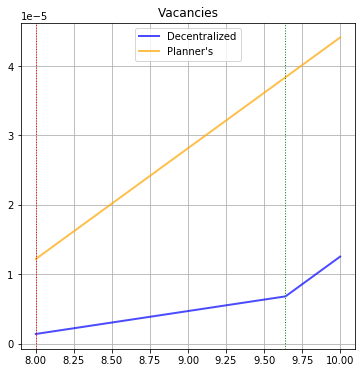

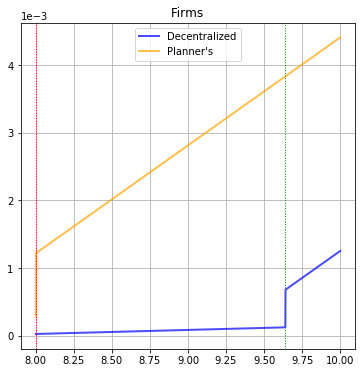

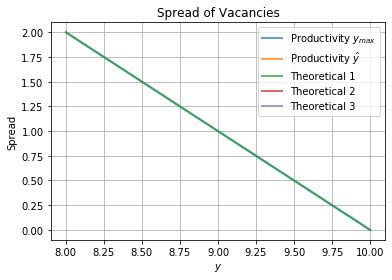

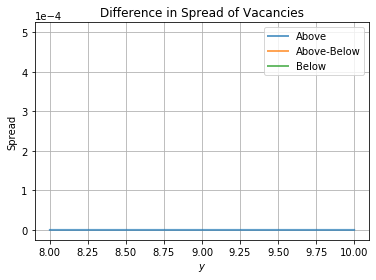

lagrangians failed to converge
0.017148059930043758 0.029993430686129585 0.005585814284710722 0.0012296547007037972
Entry above from code gives 0.6747; entry from theory gives 0.6744
Entry below from code gives -0.0001; entry from theory gives 0.0001
unemployment in model is 0.0789; according to LOM, should be 0.0789
Employees match w/prob 0.35, employers match w/prob 0.71
Number of outsourcing firms is 11.26037, number of outsourcer firms is 0.92077


In [6]:
B = 0.95
r = 1 / B - 1
delta = 0.03
eta = 0.5
phi = 5e-1 
y_min = 8
y_max = 10
b = y_min * .4
y_grid_size = 4000
gamma = 2
delta_hat = 0.01
gamma_h = 5
k = 5e5
k_h = 5e5

out = OutsourcerDiscrete(B, b, delta, delta_hat, eta, phi, y_min, y_max, y_grid_size, gamma, gamma_h, k, k_h)

tol = 1e-6
max_iter = 1e4
tol_p = 1e-8
max_iter_p = 1e4
print_skip = 50
slow = 5e-2
slow_p = 1e-3

v_grid, v_h, u, y_hat, p_h = find_p(
    out, tol, max_iter, tol_p, max_iter_p, verbose=True, print_skip=print_skip, slow=slow, slow_p=slow_p)

theta = (np.sum(v_grid[out.y_grid < y_hat]) + v_h) / u
n_grid = np.zeros(y_grid_size)
n_grid[out.y_grid < y_hat] = out.q(theta) * v_grid[out.y_grid < y_hat] / delta
n_grid[out.y_grid >= y_hat] =  v_grid[out.y_grid >= y_hat] / delta_hat

tol = 1e-4
max_iter = 2e3
tol_l = 1e-6
max_iter_l = 1e6
ps = 1e2
slow = 1e-2
slow_l = 5e-3

guess = [v_grid, v_h, u, y_hat]

v_grid_p, v_h_p, n_grid_p, n_h_p, y_hat_p = solve_p_model(
    out, guess=guess, tol_l=tol_l, tol=tol, max_iter_l=max_iter_l, max_iter=max_iter,
    verbose=True, print_skip=ps, slow=slow, slow_l=slow_l)

u_p = 1 - np.sum(n_grid_p[out.y_grid < y_hat_p]) - n_h_p
print(f"Decentralized u is {u:.3f}, Planner's u is {u_p}")

# Plot v_grids
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(out.y_grid, v_grid, lw=2, alpha=0.7, label="Decentralized", color='blue')
ax.plot(out.y_grid, v_grid_p, lw=2, alpha=0.7, label="Planner's", color='orange')
ax.axvline(x=y_hat, c='green', lw=1, linestyle=':')
ax.axvline(x=y_hat_p, c='red', lw=1, linestyle=':')
# ax.axhline(y=v_h, c='k', lw=2, linestyle='--')
ax.ticklabel_format(axis='y', style='sci', scilimits=(1,-1))
ax.grid()
ax.legend()
ax.set_title("Vacancies")

plt.show()

# Plot n_grids
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(out.y_grid, n_grid, lw=2, alpha=0.7, label="Decentralized", color='blue')
ax.plot(out.y_grid, n_grid_p, lw=2, alpha=0.7, label="Planner's", color='orange')
ax.axvline(x=y_hat, c='green', lw=1, linestyle=':')
ax.axvline(x=y_hat_p, c='red', lw=1, linestyle=':')
# ax.axhline(y=v_h, c='k', lw=2, linestyle='--')
ax.ticklabel_format(axis='y', style='sci', scilimits=(1,-1))
ax.grid()
ax.legend()
ax.set_title("Firms")

plt.show()

spread_p(out, v_grid_p, v_h_p, n_grid_p, n_h_p, y_hat_p)

entry_p(out, v_grid_p, v_h_p, n_grid_p, n_h_p, y_hat_p)

In [2]:
# Old version of the code
# Run top cell first (of old version)
# Create graph of supply and demand for outsourced workers given price p_h

# First set up iteration
def supply_demand_factory(out):
    
    B, r, b, delta, eta, gamma, k = out.B, out.r, out.b, out.delta, out.eta, out.gamma, out.k
    delta_hat, gamma_h, k_h = out.delta_hat, out.gamma_h, out.k_h
    y_grid, y_grid_size = out.y_grid, out.y_grid_size
    y_grid_max = max(y_grid)
    q, p = out.q, out.p
    
    # Use v_grid, u, v_h, and y_hat to find pi, theta and f_grid (make sure v not 0)
    @njit()
    def get_dist_SD(v_grid, v_h, u, y_hat):
        v = max(np.sum(v_grid[y_grid < y_hat]), 1e-6)    
        # Outsourcing firms not in f_grid
        f_grid = np.minimum(v_grid / v, y_grid < y_hat)
        theta = (v + v_h) / u
        pi = v_h / (v + v_h)
        
        return theta, f_grid, pi    
    
    # Find wages for each postion
    @njit()
    def prices_SD(v_grid, v_h, p_h, theta, f_grid, pi):
        # Useful to define a value of search 
        val_search = theta * ((1 - pi) * np.sum(c(v_grid, gamma, k) * f_grid) + pi * c_h(v_h, gamma_h, k_h))
#         # For some reason, val_seach likes to sometimes return vectors, change this
#         try:
#             val_search = val_search[0]
#         except:
#             val_search = val_search
        w_grid = b + eta * (y_grid - b + val_search)
        omega = b + eta * (p_h - b + val_search)
                        
        return w_grid, omega 
    
    # Find y_hat using prices
    @njit()
    def get_y_hat_SD(theta, w_grid, p_h):
        J = (y_grid - w_grid) / (r + delta)
        J_H = (y_grid - p_h) / (r + delta_hat)
        choice = 1 * (J_H >= q(theta) * J) * (J_H > 0)
        ind = np.searchsorted(choice, 0, side='right')
        # If y_hat > y_max, return y_max + 1
        if ind < y_grid_size:
            y_hat = y_grid[ind]
        else:
            y_hat = y_grid_max + 1
        return y_hat
    
    @njit()
    def iterate_SD(v_grid, v_h, u, y_hat, p_h):
        
        v_grid_new = np.empty(y_grid_size)
        
        theta, f_grid, pi = get_dist_SD(v_grid, v_h, u, y_hat)

        w_grid, omega = prices_SD(v_grid, v_h, p_h, theta, f_grid, pi)        
        
        y_hat_new = get_y_hat_SD(theta, w_grid, p_h)
        
        # Should the relevant comparison be y_hat or y_hat_new? Make switching easier
        y_comp = y_hat
        
        # Firms who hire own workers (below y_comp)
        v_grid_new[y_grid < y_comp] = (
            c_inv(q(theta) * (y_grid[y_grid < y_comp] - w_grid[y_grid < y_comp]) / (r + delta), gamma, k))
        
        # Firms who outsource workers (above y_comp)
        v_grid_new[y_grid >= y_comp] = (
            c_inv((y_grid[y_grid >= y_comp] - p_h) / (r + delta_hat), gamma, k))
        
        # v_h_new chosen using free entry
        v_h_new = c_h_inv(q(theta) * (p_h - omega) / (r + delta), gamma_h, k_h)
        
        # Update u_new using unemployed workers
        n_grid_new = q(theta) * v_grid_new[y_grid < y_comp] / delta
        u_new = max(1 - np.sum(n_grid_new) - (q(theta) * v_h_new / delta), 1e-6)
        
#         # If want to base on v_grid_new[y_grid >= y_comp] rather than v_h_new, use this
#         m_grid_new = v_grid_new[y_grid >= y_comp] / delta_hat
#         u_new = max(1 - np.sum(n_grid_new) - np.sum(n_grid_new), 1e-6)
        
        return v_grid_new, v_h_new, u_new, y_hat_new
    
    return iterate_SD, get_dist_SD, prices_SD

# Solve model given p_h
def solve_model_SD(out, p_h, tol, max_iter, slow):
    
    iterate_SD, get_dist_SD, prices_SD = supply_demand_factory(out)
    
    # Set up initial guesses and loop parameters
    v_grid = np.ones(out.y_grid_size) / out.y_grid_size
    u = 0.05
    y_hat = p_h
    v_h = 1
    i = 0
    err = tol + 1    
    
    # Update v_grid, v_h, u, and y_hat each period
    while i < max_iter and err > tol:
        v_grid_new, v_h_new, u_new, y_hat_new = iterate_SD(v_grid, v_h, u, y_hat, p_h)
        err_v = np.max(np.abs(v_grid_new - v_grid))
        err_v_h = np.abs(v_h_new - v_h)
        err_u = np.abs(u_new - u)
        err_y_hat = np.abs(y_hat_new - y_hat)
        err = max(err_v, err_v_h, err_u, err_y_hat)
        i += 1
        
        v_grid = slow * v_grid_new + (1 - slow) * v_grid
        v_h = slow * v_h_new + (1 - slow) * v_h        
        u = slow * u_new + (1 - slow) * u
        y_hat = slow * y_hat_new + (1 - slow) * y_hat
        
    return v_grid_new, v_h_new, u_new, y_hat_new, i, err


def solve_QS_QD(out, p_h_min, p_h_max, p_h_grid_size, tol, max_iter, slow):
    
    p_h_grid = np.linspace(p_h_min, p_h_max, p_h_grid_size, endpoint=False)
    
    iterate_SD, get_dist_SD, prices_SD = supply_demand_factory(out)
    
    # Create grid for QS and QD
    QS_grid, QD_grid = np.empty(p_h_grid_size), np.empty(p_h_grid_size)
    # Create a grid for theta, v_h, and va_grid (vacancies above y_hat)
    theta_grid, v_h_grid, va_grid = np.empty(p_h_grid_size), np.empty(p_h_grid_size), np.empty(p_h_grid_size)
    # Create grid for total firm vacancies
    tot_firm_grid = np.empty(p_h_grid_size)
    # Create grid for y_hat and omega
    y_hat_grid, omega_grid = np.empty(p_h_grid_size), np.empty(p_h_grid_size)
    # Create a grid for u
    u_grid = np.empty(p_h_grid_size)
    # Create grid for convergence and err
    converge_grid, err_grid = np.empty(p_h_grid_size), np.empty(p_h_grid_size)
    # Record the maximum price with poistive demand, start by assuming p_h_max
    i_max = int(p_h_max)
    
    # For each p_h, find QS and QD, which requires finding theta too
    for i, p_h in enumerate(p_h_grid):
        
        v_grid, v_h, u, y_hat, loops, err = solve_model_SD(out, p_h, tol, max_iter, slow)
        theta, f_grid, pi = get_dist_SD(v_grid, v_h, u, y_hat)
        # Supply of outsourcing are matched outsourcers, not outsourcer vacancies
        QS_grid[i] = v_h * out.q(theta) / out.delta
        v_h_grid[i] = v_h
        # Demand for outsourcing are matched firms, not firm vacancies
        QD_grid[i] = np.sum(v_grid[out.y_grid >= y_hat]) / out.delta_hat
        va_grid[i] = np.sum(v_grid[out.y_grid >= y_hat])
        # Total firm vacancies
        tot_firm_grid[i] = QD_grid[i] + np.sum(v_grid[out.y_grid < y_hat]) * out.q(theta) / out.delta
        y_hat_grid[i] = y_hat
        theta_grid[i] = theta
        _, omega = prices_SD(v_grid, v_h, p_h, theta, f_grid, pi)
        omega_grid[i] = omega
        u_grid[i] = u
        converge_grid[i] = (loops < max_iter)
        err_grid[i] = err
#         print(f'Cost is {out.q(theta) * (p_h - omega) / (r + delta)}')

        # If QD_grid[i] == 0, stop the program and record i_max
        if QD_grid[i] == 0:
            i_max = i
            break
        
        
    return (QS_grid, QD_grid, tot_firm_grid, v_h_grid, va_grid, theta_grid,
            y_hat_grid, omega_grid, u_grid, converge_grid, err_grid, i_max) 

# Graph results
def supply_demand(out, p_h_min, p_h_max, p_h_grid_size, tol=1e-4, max_iter=1000, slow=1/100,
           save=False, folder=r'C:\Users\spspi\Dropbox\Documents\Outsourcing\Figures', file='\Outsourcers\SD'):
    
    p_h_grid = np.linspace(p_h_min, p_h_max, p_h_grid_size, endpoint=False)
    
    (QS_grid, QD_grid, tot_firm_grid, v_h_grid, va_grid, theta_grid,
     y_hat_grid, omega_grid, u_grid, converge_grid, err_grid, i_max
    ) = solve_QS_QD(out, p_h_min, p_h_max, p_h_grid_size, tol, max_iter, slow)
        
    fig, ax = plt.subplots()
    ax.plot(QS_grid[:i_max], p_h_grid[:i_max], lw=2, alpha=0.7, label='Supply')
    ax.plot(QD_grid[:i_max], p_h_grid[:i_max], lw=2, alpha=0.7, label='Demand')
    ax.set(xlabel='$n$', ylabel='$p_h$', title='Supply and Demand of Outsourcing')
    ax.legend(loc='best')
    ax.grid()
    
    if save:
        fig.savefig(folder + file)
    else:
        plt.show() 
        
    fig, ax = plt.subplots()
    ax.plot(QS_grid[:i_max], p_h_grid[:i_max], lw=2, alpha=0.7, label='Supply')
    ax.plot(v_h_grid[:i_max], p_h_grid[:i_max], lw=2, alpha=0.7, label='Vacancies')
    ax.set(xlabel='$n$', ylabel='$p_h$', title='Supply of Outsourcing vs Vacancies')
    ax.legend(loc='best')
    ax.grid()
    
    if save:
        fig.savefig(folder + file + 'Supply')
    else:
        plt.show()
        
    fig, ax = plt.subplots()
    ax.plot(QD_grid[:i_max], p_h_grid[:i_max], lw=2, alpha=0.7, label='Demand')
    ax.plot(va_grid[:i_max], p_h_grid[:i_max], lw=2, alpha=0.7, label='Vacancies')
    ax.set(xlabel='$n$', ylabel='$p_h$', title='Demand for Outsourcing vs Vacancies')
    ax.legend(loc='best')
    ax.grid()
    
    if save:
        fig.savefig(folder + file + 'Demand')
    else:
        plt.show()
        
    fig, ax = plt.subplots()
    ax.plot(p_h_grid[:i_max], QD_grid[:i_max] - QS_grid[:i_max], lw=2, alpha=0.7)
    ax.axhline(y=0, ls=':', c='k')
    ax.set(xlabel='$p_h$', ylabel=r'$QD - QS$', title='$QD - QS$ Given Price $p_h$')
    ax.grid()
    
    if save:
        fig.savefig(folder + file + '_qd_min_qs')
    else:
        plt.show()   
        
    fig, ax = plt.subplots()
    ax.plot(p_h_grid[:i_max], QD_grid[:i_max] / tot_firm_grid[:i_max] * 100, lw=2, alpha=0.7)
    ax.axhline(y=0, ls=':', c='k')
    ax.set(xlabel='$p_h$', ylabel=r'%', title='Percent of Postions Outsourced')
    ax.grid()
    
    if save:
        fig.savefig(folder + file + 'per_out')
    else:
        plt.show() 
        
    fig, ax = plt.subplots()
    ax.plot(p_h_grid[:i_max], theta_grid[:i_max], lw=2, alpha=0.7)
    ax.set(xlabel='$p_h$', ylabel=r'$\theta$', title='$\\theta$ Given Price $p_h$')
    ax.grid()
    
    if save:
        fig.savefig(folder + file + '_theta')
    else:
        plt.show() 
        
    p_grid = np.empty_like(theta_grid)
    q_grid = np.empty_like(theta_grid)
    for ind, theta in enumerate(theta_grid):
        p_grid[ind] = out.p(theta)
        q_grid[ind] = out.q(theta)
        
    fig, ax = plt.subplots()
    ax.plot(p_h_grid[:i_max], p_grid[:i_max], lw=2, alpha=0.7, label=r'$p(\theta)$')
    ax.plot(p_h_grid[:i_max], q_grid[:i_max], lw=2, alpha=0.7, label=r'$q(\theta)$')
    ax.set(xlabel='$p_h$', ylabel=r'Matching Probability', title='Matching Probabilities')
    ax.legend()
    ax.grid()
    
    if save:
        fig.savefig(folder + file + '_match_prob')
    else:
        plt.show() 
        
        
    y_min = min(out.y_grid)
    y_max = max(out.y_grid)
    fig, ax = plt.subplots()
    ax.plot(p_h_grid[:i_max], y_hat_grid[:i_max], lw=2, alpha=0.7)
    ax.axhline(y=y_min, ls=':', c='k')
    ax.axhline(y=y_max, ls=':', c='k')
    ax.set(xlabel='$p_h$', ylabel='$y^*$', title='$y^*$ Given Price $p_h$')
    ax.grid()
    
    if save:
        fig.savefig(folder + file + '_y_hat')
    else:
        plt.show() 
        
    fig, ax = plt.subplots()
    ax.plot(p_h_grid[:i_max], omega_grid[:i_max], lw=2, alpha=0.7)
    ax.set(xlabel='$p_h$', ylabel='$\omega$', title='Wage Given Price $p_h$')
    ax.grid()
    
    if save:
        fig.savefig(folder + file + '_omega')
    else:
        plt.show() 
        
    fig, ax = plt.subplots()
    ax.plot(p_h_grid[:i_max], u_grid[:i_max], lw=2, alpha=0.7, label='u_model')    
    ax.set(xlabel='$p_h$', ylabel='$u$', title='Unemployment Given Price $p_h$')
    ax.grid()
    
    if save:
        fig.savefig(folder + file + '_u')
    else:
        plt.show() 
    
    
    u_lom_grid = np.empty_like(theta_grid)
    for ind, theta in enumerate(theta_grid):
        u_lom_grid[ind] = delta / (delta + out.p(theta))
    
    fig, ax = plt.subplots()
    ax.plot(p_h_grid[:i_max], u_grid[:i_max], lw=2, alpha=0.7, label='u_model')    
    ax.plot(p_h_grid[:i_max], u_lom_grid[:i_max], lw=2, alpha=0.7, label='u_lom')
    ax.set(xlabel='$p_h$', ylabel='$u$', title='Unemployment Given Price $p_h$')
    ax.legend()
    ax.grid()
    
    if save:
        fig.savefig(folder + file + '_u_check')
    else:
        plt.show() 
        
    fig, ax = plt.subplots()
    ax.plot(p_h_grid[:i_max], converge_grid[:i_max], lw=2, alpha=0.7)
    ax.set(xlabel='$p_h$', ylabel='converge', title='Converge Given Price $p_h$')
    ax.set_ylim(-0.05, 1.05)
    ax.grid()
    
    if save:
        fig.savefig(folder + file + '_converge')
    else:
        plt.show() 
        
    fig, ax = plt.subplots()
    ax.plot(p_h_grid[:i_max], err_grid[:i_max], lw=2, alpha=0.7)
    ax.set(xlabel='$p_h$', ylabel='err', title='Err Given Price $p_h$')
    ax.grid()
    
    if save:
        fig.savefig(folder + file + '_err')
    else:
        plt.show() 

In [ ]:
# Run top cell first
# This code tries to iterate over all values at once. Not converging, can't figure out what is wrong

def operator_factory(out):
    "Use an outsourcer case out and create a function to find next vacancy and unemployment iterations"
    
    B, r, b, delta, eta, alpha, k = out.B, out.r, out.b, out.delta, out.eta, out.alpha, out.k
    delta_hat, alpha_h, k_h = out.delta_hat, out.alpha_h, out.k_h
    y_grid, y_grid_size = out.y_grid, out.y_grid_size
    y_grid_max = max(y_grid)
    q, p = out.q, out.p
    
    # Use v_grid, u, v_h, and y_star to find pi, theta and f_grid (make sure v not 0)
    def get_dist(v_grid, v_h, u, y_star):
        v = max(np.sum(v_grid[y_grid < y_star]), 1e-5)    
        # Outsourcing firms not in f_grid
        f_grid = np.minimum(v_grid / v, y_grid < y_star)
        theta = (v + v_h) / u
        pi = v_h / (v + v_h)
        
        return theta, f_grid, pi 
    
    # Define a value of searching 
    def val_search(v_grid, v_h, theta, f_grid, pi):
        val_search = theta * ((1 - pi) * np.sum(c(v_grid, alpha, k) * f_grid) + pi * c_h(v_h, alpha_h, k_h))
        # For some reason, val_seach likes to sometimes return vectors, change this
        try:
            val_search = val_search[0]
        except:
            val_search = val_search
        return val_search
    
    # Find wages for each postion and prices charged by outsourcer
    def prices(v_grid, v_h, theta, f_grid, pi):
        v_s = val_search(v_grid, v_h, theta, f_grid, pi)     
        p_h = b + eta / (1 - eta) * v_s + (r + delta) / (q(theta) * (1 - eta)) * c_h(v_h, alpha_h, k_h)
#         # Try defining prices through free entry
#         p_h = (c_h(v_h, alpha_h, k_h) + v_s) / (1 - eta) + b
        w_grid = b + eta * (y_grid - b + v_s)
        omega = b + eta * (p_h - b + v_s)
                        
        return w_grid, omega, p_h  
    
    # Find y_star with a theoretical formula
    def get_y_star(v_grid, v_h, theta, f_grid, pi):
        v_s = val_search(v_grid, v_h, theta, f_grid, pi)
        y_star = (
            b + eta / (1 - eta) * v_s
            + ((r + delta)**2 / ((1 - eta) * q(theta) * (r + delta - (1 - eta) * (r + delta_hat) * q(theta)))
               * c_h(v_h, alpha_h, k_h)))  
        return y_star
    
#     # Find y_star using prices (seem to give similar values)
#     def get_y_star(v_grid, v_h, theta, pi, f_grid):
#         w_grid, omega, p_h = prices(v_grid, v_h, theta, pi, f_grid)
#         J = (y_grid - w_grid) / (r + delta)
#         J_H = (y_grid - p_h) / (r + delta_hat)
#         choice = 1 * (J_H >= q(theta) * J)
#         ind = np.searchsorted(choice, 0, side='right') 
#         return y_grid[ind]
#         # If y_star > y_max, return y_max + 1
#         try:
#             y_star = y_grid[ind]
#         except:
#             y_star = y_max + 1
#         return y_star
    
    def iterate(v_grid, v_h, u, y_star, slow=1):
        
        v_grid_new = np.empty(y_grid_size)
        
        theta, f_grid, pi = get_dist(v_grid, v_h, u, y_star)

        w_grid, omega, p_h = prices(v_grid, v_h, theta, pi, f_grid)

        # Firms who hire own workers (below y_star)
        v_grid_new[y_grid < y_star] = (
            c_inv(q(theta) * (y_grid[y_grid < y_star] - w_grid[y_grid < y_star]) / (r + delta), alpha, k))
        
        # Firms who outsource workers (above y_star)
        v_grid_new[y_grid >= y_star] = (
            c_inv((y_grid[y_grid >= y_star] - p_h) / (r + delta_hat), alpha, k))
        
        # Update st st unemployment
        u_new = delta / (delta + p(theta))
        
#         # Set v_h_new proportional to all vacancies from above y_star (market clearing)
#         v_h_new = delta / (delta_hat * q(theta)) * np.sum(v_grid[y_grid >= y_star])
        
        # v_h_new chosen using free entry
        v_h_new = c_h_inv(q(theta) * (p_h - omega) / (r + delta), alpha_h, k_h)
        
        # Update y_star
        y_star_new = get_y_star(v_grid_new, v_h_new, theta, pi, f_grid)
        
        v_grid_new = slow * v_grid_new + (1 - slow) * v_grid
        v_h_new = slow * v_h_new + (1 - slow) * v_h
        u_new = slow * u_new + (1 - slow) * u
        y_star_new = slow * y_star_new + (1 - slow) * y_star
        
        return v_grid_new, v_h_new, u_new, y_star_new
    
    return iterate, get_dist, prices, get_y_star

def solve_model(out, tol=1e-4, max_iter=1000, verbose=True, print_skip=25):
    
    iterate, get_dist, prices, get_y_star = operator_factory(out)
    
    # Set up initial guesses and loop parameters
    v_grid = np.ones(out.y_grid_size) / out.y_grid_size
    u = 0.05
    y_star = np.max(out.y_grid) / 2
    v_h = out.y_grid_size
    i = 0
    err = tol + 1    
    # To not converge too fast, use slow to put more weight on initial value
#     slow = 1 / out.y_grid_size
    slow = 1 / 100
    
    # Update v_grid, v_h, u, and y_star each period
    while i < max_iter and err > tol:
        v_grid_new, v_h_new, u_new, y_star_new = iterate(v_grid, v_h, u, y_star, slow)
        err_v = np.max(np.abs(v_grid_new - v_grid))
        err_v_h = np.abs(v_h_new - v_h)
        err_u = np.abs(u_new - u)
        err_y_star = np.abs(y_star_new - y_star)
        err = max(err_v, err_v_h, err_u, err_y_star)
        i += 1

        if verbose and i % print_skip == 0:
            print(f'Error at iter {i} is {err}')
            theta, f_grid, pi = get_dist(v_grid_new, v_h_new, u_new, y_star_new)
            w_grid, omega, p_h = prices(v_grid_new, v_h_new, theta, f_grid, pi)
            print(u_new, theta, out.q(theta), out.p(theta))
            print(v_h_new, p_h, y_star_new, pi)

        if verbose and i % print_skip == 1:
            print(f'Error at iter {i} is {err}')
            theta, f_grid, pi = get_dist(v_grid_new, v_h_new, u_new, y_star_new)
            w_grid, omega, p_h = prices(v_grid_new, v_h_new, theta, f_grid, pi)
            print(u_new, theta, out.q(theta), out.p(theta))
            print(v_h_new, p_h, y_star_new, pi)

#         if verbose and i >= 0 and i <= 5:
#             print(f'Error at iter {i} is {err}')
#             theta, f_grid, pi = get_dist(v_grid_new, v_h_new, u_new, y_star_new)
#             w_grid, omega, p_h = prices(v_grid_new, v_h_new, theta, f_grid, pi)
#             print(u_new, theta, out.q(theta), out.p(theta))
#             print(v_h_new, p_h, y_star_new, pi)
            
#         if verbose and y_star <= max(out.y_grid):
#             print(f'At iter {i} y_star is {y_star}')
#             theta, f_grid, pi = get_dist(v_grid_new, v_h_new, u_new, y_star_new)
#             w_grid, omega, p_h = prices(v_grid_new, v_h_new, theta, f_grid, pi)
#             print(u_new, theta, out.q(theta), out.p(theta))
#             print(v_h_new, p_h, y_star_new, pi)

        v_grid, v_h, u, y_star = v_grid_new, v_h_new, u_new, y_star_new
     
#     # Run one more iteration without slow to get rid of 0 values
#     v_grid_new, v_h_new, u_new, y_star_new = iterate(v_grid_new, v_h_new, u_new, y_star_new)
    
    if i == max_iter:
        print("Failed to Converge")
        
    if verbose and i < max_iter:
        print(f'Converged in {i} iterations')
    
    return v_grid_new, v_h_new, u_new, y_star_new  

# Can check code against theoretical results by looking at spread and number of entrants
# For spread of entrants, compare each firms entry to highest. Graph results
# Spread depends on relation to y_star
# Keep in mind that spread_theory doesn't know that vacancies cannot be negative
def spread(out, v_grid, v_h, u, y_star,
           save=False, folder=r'C:\Users\spspi\Dropbox\Documents\Outsourcing\Figures', file='\Outsourcers\Spread'):
    
    alpha, eta, r, delta = out.alpha, out.eta, out.r, out.delta
    q, y_grid = out.q, out.y_grid
    
    iterate, get_dist, wages = operator_factory(bl)
    theta, f_grid = get_dist(v_grid, u)
    
    spread_code = c(v_grid[-1], alpha) - c(v_grid, alpha, k)
    spread_theory = (y_grid[-1] - y_grid) * (1 - eta) * q(theta) / (r + delta)
    spread_theory[v_grid == 0] = c(v_grid[-1], alpha, k)
    dif = spread_code - spread_theory
    
    fig, ax = plt.subplots()
    ax.plot(y_grid, spread_code, lw=2, alpha=0.7, label='Code')
    ax.plot(y_grid, spread_theory, lw=2, alpha=0.7, label='Theoretical')
    ax.plot(y_grid, dif, lw=2, alpha=0.7, label='Difference')
    ax.set(xlabel='$y$', ylabel='Spread of Marginal Cost', title='Spread of Vacancies')
    ax.legend(loc='best')
    ax.grid()
    
    if save:
        fig.savefig(folder + file)
    else:
        plt.show()   
        
    fig, ax = plt.subplots()
    ax.plot(y_grid, dif, lw=2, alpha=0.7)
    ax.set(xlabel='$y$', ylabel='Spread of Marginal Cost', title='Difference in Spread of Vacancies')
    ax.grid()
    
    if save:
        fig.savefig(folder + file + '_dif')
    else:
        plt.show()  

Error at iter 1 is 1380521701606.278
0.047912621359223306 227.49746707193515 0.050055193550258885 1.0
10.0 53003739690753.89 1380521701611.278 0.9174311926605504
Error at iter 500 is 1.642578125
0.02912621359223303 343.3336766666664 0.04074546004851053 1.0
10.0 86847330706893.28 1029900845765.7935 0.9999990000010001
Error at iter 501 is 1.4783935546875
0.02912621359223303 343.3336766666664 0.04074546004851053 1.0
10.0 86847330706893.28 1029900845764.3151 0.9999990000010001
Error at iter 1000 is 1.0411376953125
0.02912621359223303 343.3336766666664 0.04074546004851053 1.0
10.0 86847330706893.28 1029900845760.3796 0.9999990000010001
Error at iter 1001 is 4.3983154296875
0.02912621359223303 343.3336766666664 0.04074546004851053 1.0
10.0 86847330706893.28 1029900845764.778 0.9999990000010001
Failed to Converge
343.3336766666664 0.9999990000010001 0.04074546004851053 1.0


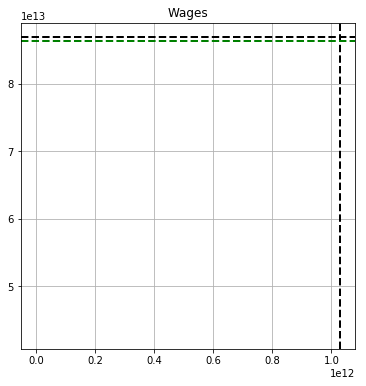

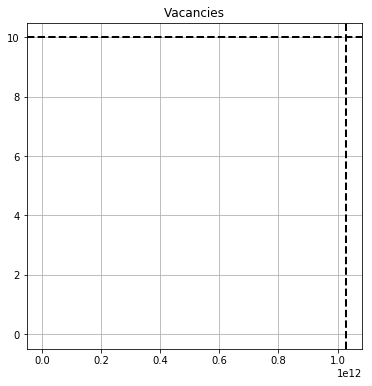

In [48]:
B = 0.95
r = 1 / B - 1
b = 0
delta = 0.03
eta = 0.5
# phi = 5e-2
u_set = 0.05
phi = np.sqrt(delta / u_set - delta) 
y_min = 1
y_max = 10
y_grid_size = 10
alpha = 2
delta_hat = 0.01
alpha_h = 5
k = 5000000
k_h = 5000000

out = OutsourcerDiscrete(B, b, delta, delta_hat, eta, phi, y_min, y_max, y_grid_size, alpha, alpha_h, k, k_h)
iterate, get_dist, prices, get_y_star = operator_factory(out)

v_grid, v_h, u, y_star = solve_model(out, tol=1e-4, print_skip=500, max_iter=1001)

theta, f_grid, pi = get_dist(v_grid, v_h, u, y_star)
w_grid, omega, p_h  = prices(v_grid, v_h, theta, f_grid, pi)

# print(theta * ((1 - pi) * np.sum(c(v_grid, alpha) * f_grid) + pi * c_h(v_h, alpha_h)))
print(theta, pi, out.q(theta), out.p(theta))
# print(np.sum(v_grid))

# Plot v_grid and w_grid with y_star dotted vert line
# Wage has dotted horizontal line for p and omega, Vacancy has a dotted horizontal line for v_h
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(out.y_grid, w_grid, lw=2, alpha=0.7)
ax.axvline(x=y_star, c='k', lw=2, linestyle='--')
ax.axhline(y=p_h, c='k', lw=2, linestyle='--')
ax.axhline(y=omega, c='g', lw=2, linestyle='--')
ax.grid()
ax.set_title("Wages")

plt.show()

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(out.y_grid, v_grid, lw=2, alpha=0.7)
ax.axvline(x=y_star, c='k', lw=2, linestyle='--')
ax.axhline(y=v_h, c='k', lw=2, linestyle='--')
ax.grid()
ax.set_title("Vacancies")

plt.show()

In [134]:
# Add outsourcers, who can sell labor to firms in frictionless markets
# Try 2. Instead of carrying around u and v_h, impute them based on v_grid and y_star

import numpy as np
from interpolation import interp
import matplotlib.pyplot as plt
import quantecon as qe
from numba import jit, njit, prange, vectorize
from scipy import optimize
from IPython.core.debugger import set_trace

# Want to vectorize cost of vacancy, marginal cost of vacancy, and inverse marginal cost of vacancy
@vectorize
def C(v, alpha=2):
    return v**alpha

@vectorize
def c(v, alpha=2):
    return alpha * v**(alpha - 1)
     
@vectorize
def c_inv(c, alpha=2):
    if c > 0:
        return (c / alpha)**(1 / (alpha - 1))
    else:
        return 0

# Do the same for outsourcers, who have C^H(v) = v**alpha_h
@vectorize
def C_h(v, alpha_h=1.5):
    return v**alpha_h

@vectorize
def c_h(v, alpha_h=1.5):
    if v > 0:
        return alpha_h * v**(alpha_h - 1)
    else:
        return 0
     
@vectorize
def c_h_inv(c, alpha_h=1.5):
    if c > 0:
        return (c / alpha_h)**(1 / (alpha_h - 1))
    else:
        return 0
    
# Set up the baseline environment, starting with a discrete model
class OutsourcerDiscrete:
    """
    B is discount rate beta
    r is interest rate defined by beta
    b is home production
    delta is job loss rate
    delta_hat is firm destruction rate <= delta
    eta is worker bargaining power    
    phi is effectiveness of matching function
    q is firm's matching function, worker's is p=theta*q(theta)
    y_min, y_max, y_grid_size determine productivity grid
    alpha is steepness of marginal cost
    alpha_h is steepness of marginal cost for outsourcer
    q is matching function of firms
    p is matching function of workers
    
    q_p is derivative of firm's matching function for Planner's
    n_min, n_max, n_grid_size determines n_grid for Planner's
    """
    def __init__(self, B, b, delta, delta_hat, eta, phi,
                 y_min, y_max, y_grid_size, alpha, alpha_h, n_min=0, n_max=1, n_grid_size=10):
        
        self.B, self.b, self.delta, self.eta, self.alpha = B, b, delta, eta, alpha
        self.delta_hat, self.alpha_h = delta_hat, alpha_h 
        self.r = 1 / B - 1
        
        self.y_grid = np.linspace(y_min, y_max, y_grid_size)
        self.y_grid_size = y_grid_size        
        
        self.q = njit(lambda x: min(phi * x**(-1 / 2), 1))
        self.p = njit(lambda x: min(phi * x**(1 / 2), 1))
        self.q_p = njit(lambda x: -phi / 2 * x**(-3 / 2)) 
        self.p_p = njit(lambda x: phi / 2 * x**(1 / 2))
        
        self.n_grid_size = n_grid_size
        self.n_grid = np.linspace(n_min, n_max, n_grid_size)
        
# Set up functions of Outsourcer problem
def operator_factory(out):
    "Use an outsourcer case out and create a function to find next vacancy and unemployment iterations"
    
    B, r, b, delta, eta, alpha = out.B, out.r, out.b, out.delta, out.eta, out.alpha
    delta_hat, alpha_h = out.delta_hat, out.alpha_h
    y_grid, y_grid_size = out.y_grid, out.y_grid_size
    y_grid_max = max(y_grid)
    q, p = out.q, out.p
    q_p, p_p = out.q_p, out.p_p
    
    # Define a system of eqs and jacobian to find v_h and u
    def sys(x, v_grid, y_star):
        v_h = x[0]
        u = x[1]
        v = max(np.sum(v_grid[y_grid < y_star]), 1 / (y_grid_size * 10000))
        theta = (v + v_h) / u
        return np.array([v_h * (delta_hat * q(theta)) - delta * max(np.sum(v_grid[y_grid >= y_star]), 1e-5),
                         u * (delta + p(theta)) - delta])

    def jac(x, v_grid, y_star):
        v_h = x[0]
        u = x[1]
        v = max(np.sum(v_grid[y_grid < y_star]), 1 / (y_grid_size * 10000))
        theta = (v + v_h) / u
        d1dv_h = delta_hat * (v_h * q_p(theta) + q(theta))
        d1du = delta_hat * v_h * q_p(theta) * (theta / u)
        d2dv_h = u * p_p(theta)
        d2du = delta + p(theta) + theta * p_p(theta)
        return np.array([[d1dv_h, d1du], [d2dv_h, d2du]])
    
    # Use v_grid and y_star to find u, v_h, theta, pi, and f_grid (make sure v not 0)
    def get_dist(v_grid, y_star):
        v = max(np.sum(v_grid[y_grid < y_star]), 1 / (y_grid_size * 10000))    
        # Outsourcing firms not in f_grid
        f_grid = np.minimum(v_grid / v, y_grid < y_star)
        # Use system of eqs to find v_h and u
        v_h, u = optimize.root(sys, (1, .05), args=(v_grid, y_star), jac=jac, method='lm', options={'factor':.1}).x
        theta = (v + v_h) / u
        pi = v_h / (v + v_h)
        
        return v_h, u, theta, f_grid, pi    
    
    # Find wages for each postion and prices charged by outsourcer
    def prices(v_grid, v_h, theta, f_grid, pi):
        # Useful to define a value of search 
        val_search = theta * ((1 - pi) * np.sum(c(v_grid, alpha) * f_grid) + pi * c_h(v_h, alpha_h))
        # For some reason, val_seach likes to sometimes return vectors, change this
        try:
            val_search = val_search[0]
        except:
            val_search = val_search
            
        p_h = b + eta / (1 - eta) * val_search + (r + delta) / (q(theta) * (1 - eta)) * c_h(v_h, alpha_h)
        w_grid = np.minimum(b + eta * (y_grid - b + val_search), y_grid)
        omega = np.minimum(b + eta * (p_h - b + val_search), p_h)
                        
        return w_grid, omega, p_h  
    
    # Find y_star with a theoretical formula
    def get_y_star(v_grid, v_h, theta, f_grid, pi):
        # Useful to define a value of search 
        val_search = theta * ((1 - pi) * np.sum(c(v_grid, alpha) * f_grid) + pi * c_h(v_h, alpha_h))
        # For some reason, val_seach likes to sometimes return vectors, change this
        try:
            val_search = val_search[0]
        except:
            val_search = val_search
            
        y_star = (
            b + eta / (1 - eta) * val_search 
            + ((r + delta)**2 / ((1 - eta) * q(theta) * (r + delta - (1 - eta) * (r + delta_hat) * q(theta)))
               * c_h(v_h, alpha_h)))  
        return y_star
    
#     # Find y_star using prices (seem to give similar values)
#     def get_y_star(v_grid, v_h, theta, pi, f_grid):
#         w_grid, omega, p_h = prices(v_grid, v_h, theta, pi, f_grid)
#         J = (y_grid - w_grid) / (r + delta)
#         J_H = (y_grid - p_h) / (r + delta_hat)
#         choice = 1 * (J_H >= q(theta) * J)
#         ind = np.searchsorted(choice, 0, side='right') 
#         return y_grid[ind]
    
    def iterate(v_grid, y_star, slow=1):
        
        v_h, u, theta, f_grid, pi = get_dist(v_grid, y_star)

        w_grid, omega, p_h = prices(v_grid, v_h, theta, pi, f_grid)

        # Firms who hire own workers 
        v_grid_new_1 = c_inv(q(theta) * (y_grid - w_grid) / (r + delta), alpha)
        
        # Firms who outsource workers 
        v_grid_new_2 = c_inv((y_grid - p_h) / (r + delta_hat), alpha)
        
        # Firms choose max of these
        v_grid_new = np.maximum(v_grid_new_1, v_grid_new_2)
        
        # Use this to update y_star
        choice = 1 * (v_grid_new_2 > v_grid_new_1)
        y_ind = np.searchsorted(choice, 0, side='right')
        # Make sure if y_star is bigger than y_max, does not return y_max
        if y_ind < y_grid_size:
            y_star_new = y_grid[y_ind]
        else:
            y_star_new = max(y_grid) + 1
        
        v_grid_new = slow * v_grid_new + (1 - slow) * v_grid
        y_star_new = slow * y_star_new + (1 - slow) * y_star
        
        return v_grid_new, y_star_new
    
    return sys, jac, iterate, get_dist, prices, get_y_star

def solve_model(out, tol=1e-4, max_iter=1000, verbose=True, print_skip=25):
    
    sys, jac, iterate, get_dist, prices, get_y_star = operator_factory(out)
    
    # Set up initial guesses and loop parameters
    v_grid = np.ones(out.y_grid_size) / out.y_grid_size
    y_star = np.max(out.y_grid) / 2
    i = 0
    err = tol + 1    
    # To not converge too fast, use slow to put more weight on initial value
    slow = 1 / out.y_grid_size
    
    # Update v_grid, v_h, u, and y_star each period
    while i < max_iter and err > tol:
        v_grid_new, y_star_new = iterate(v_grid, y_star, slow)
        err_v = np.max(np.abs(v_grid_new - v_grid))
        err_y_star = np.abs(y_star_new - y_star)
        err = max(err_v, err_y_star)
        i += 1

        if verbose and i % print_skip == 0:
            print(f'Error at iter {i} is {err}')
            v_h, u, theta, f_grid, pi = get_dist(v_grid_new, y_star_new)
            w_grid, omega, p_h = prices(v_grid_new, v_h, theta, f_grid, pi)
            print(u, theta, out.q(theta), out.p(theta))
            print(v_h, p_h, y_star_new, pi)

        if verbose and i % print_skip == 1:
            print(f'Error at iter {i} is {err}')
            v_h, u, theta, f_grid, pi = get_dist(v_grid_new, y_star_new)
            w_grid, omega, p_h = prices(v_grid_new, v_h, theta, f_grid, pi)
            print(u, theta, out.q(theta), out.p(theta))
            print(v_h, p_h, y_star_new, pi)

#         if verbose and i >= 0 and i <= 5:
#             print(f'Error at iter {i} is {err}')
#             theta, f_grid, pi = get_dist(v_grid_new, v_h_new, u_new, y_star_new)
#             w_grid, omega, p_h = prices(v_grid_new, v_h_new, theta, f_grid, pi)
#             print(u_new, theta, out.q(theta), out.p(theta))
#             print(v_h_new, p_h, y_star_new, pi)
            
#         if verbose and y_star <= max(out.y_grid):
#             print(f'At iter {i} y_star is {y_star}')
#             theta, f_grid, pi = get_dist(v_grid_new, v_h_new, u_new, y_star_new)
#             w_grid, omega, p_h = prices(v_grid_new, v_h_new, theta, f_grid, pi)
#             print(u_new, theta, out.q(theta), out.p(theta))
#             print(v_h_new, p_h, y_star_new, pi)

        v_grid, y_star = v_grid_new, y_star_new
     
#     # Run one more iteration without slow to get rid of 0 values
#     v_grid_new, v_h_new, u_new, y_star_new = iterate(v_grid_new, v_h_new, u_new, y_star_new)
    
    if i == max_iter:
        print("Failed to Converge")
        
    if verbose and i < max_iter:
        print(f'Converged in {i} iterations')
    
    return v_grid_new, y_star_new  

# Can check code against theoretical results by looking at spread and number of entrants
# For spread of entrants, compare each firms entry to highest. Graph results
# Spread depends on relation to y_star
# Keep in mind that spread_theory doesn't know that vacancies cannot be negative
def spread(out, v_grid, v_h, u, y_star,
           save=False, folder=r'C:\Users\spspi\Dropbox\Documents\Outsourcing\Figures', file='\Outsourcers\Spread'):
    
    alpha, eta, r, delta = out.alpha, out.eta, out.r, out.delta
    q, y_grid = out.q, out.y_grid
    
    iterate, get_dist, wages = operator_factory(bl)
    theta, f_grid = get_dist(v_grid, u)
    
    spread_code = c(v_grid[-1], alpha) - c(v_grid, alpha)
    spread_theory = (y_grid[-1] - y_grid) * (1 - eta) * q(theta) / (r + delta)
    spread_theory[v_grid == 0] = c(v_grid[-1], alpha)
    dif = spread_code - spread_theory
    
    fig, ax = plt.subplots()
    ax.plot(y_grid, spread_code, lw=2, alpha=0.7, label='Code')
    ax.plot(y_grid, spread_theory, lw=2, alpha=0.7, label='Theoretical')
    ax.plot(y_grid, dif, lw=2, alpha=0.7, label='Difference')
    ax.set(xlabel='$y$', ylabel='Spread of Marginal Cost', title='Spread of Vacancies')
    ax.legend(loc='best')
    ax.grid()
    
    if save:
        fig.savefig(folder + file)
    else:
        plt.show()   
        
    fig, ax = plt.subplots()
    ax.plot(y_grid, dif, lw=2, alpha=0.7)
    ax.set(xlabel='$y$', ylabel='Spread of Marginal Cost', title='Difference in Spread of Vacancies')
    ax.grid()
    
    if save:
        fig.savefig(folder + file + '_dif')
    else:
        plt.show()  

Error at iter 1 is 0.5999999999999996
0.04469828473358455 121.65237874759671 0.04533250327947099 1.0
4.987652663777948 387.8293358699171 5.6 0.9172437027841805
Converged in 85 iterations
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [-205.99538773 -193.8934769  -181.79156607 -169.68965525 -157.58774442
 -145.48583359 -133.38392276 -121.28201193 -109.18010111  -97.07819028]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.4696136  0.04967718]


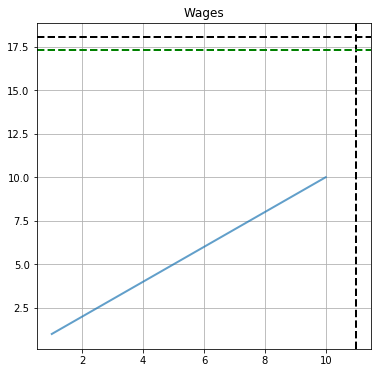

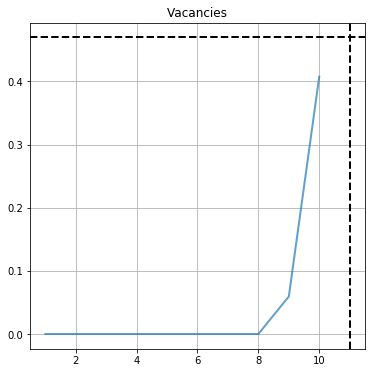

In [135]:
B = 0.95
r = 1 / B - 1
b = 0
delta = 0.03
eta = 0.5
phi = 5e-1
y_min = 1
y_max = 10
y_grid_size = 10
alpha = 2
delta_hat = 0.03
alpha_h = 1.5

out = OutsourcerDiscrete(B, b, delta, delta_hat, eta, phi, y_min, y_max, y_grid_size, alpha, alpha_h)
sys, jac, iterate, get_dist, prices, get_y_star = operator_factory(out)

v_grid, y_star = solve_model(out, print_skip=500, max_iter=10000)

v_h, u, theta, f_grid, pi = get_dist(v_grid, y_star)
w_grid, omega, p_h  = prices(v_grid, v_h, theta, f_grid, pi)

J = q(theta) * (out.y_grid - w_grid) / (r + delta)
J_H = (out.y_grid - p_h) / (r + delta_hat)
print(J, J_H)
print(c_inv(J, alpha), c_inv(J_H, alpha))

# v_grid_new_1 = c_inv(out.q(theta) * (out.y_grid - w_grid) / (r + delta), alpha)
# v_grid_new_2 = c_inv((out.y_grid - p_h) / (r + delta_hat), alpha)
# print(v_grid_new_1, v_grid_new_2)

# v_grid_new = np.maximum(v_grid_new_1, v_grid_new_2)
# choice = 1 * (v_grid_new_2 > v_grid_new_1)
# print(choice)

# y_ind = np.searchsorted(choice, 0, side='right')
# # Make sure if y_star is bigger than y_max, does not return y_max
# if y_ind < y_grid_size:
#     y_star_new = y_grid[y_ind]
# else:
#     y_star_new = max(y_grid) + 1
# print(y_ind, y_star_new)

print(optimize.root(sys, (1, .05), args=(v_grid, y_star), jac=jac, method='lm', options={'factor':.1}).x)

# Plot v_grid and w_grid with y_star dotted vert line
# Wage has dotted horizontal line for p and omega, Vacancy has a dotted horizontal line for v_h
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(out.y_grid, w_grid, lw=2, alpha=0.7)
ax.axvline(x=y_star, c='k', lw=2, linestyle='--')
ax.axhline(y=p_h, c='k', lw=2, linestyle='--')
ax.axhline(y=omega, c='g', lw=2, linestyle='--')
ax.grid()
ax.set_title("Wages")

plt.show()

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(out.y_grid, v_grid, lw=2, alpha=0.7)
ax.axvline(x=y_star, c='k', lw=2, linestyle='--')
ax.axhline(y=v_h, c='k', lw=2, linestyle='--')
ax.grid()
ax.set_title("Vacancies")

plt.show()

In [157]:
%debug

> <ipython-input-142-e77a736b552d>(38)prices()
     36                + (r + delta) / (q(theta) * (1 - eta)) * c_h(v_h, alpha_h))
     37         #p_h = np.minimum(p_h, y_grid_max)
---> 38         if any(p_h < 0):
     39             print(val_search(v_grid, v_h, theta, f_grid, pi))
     40         w_grid = b + eta * (y_grid - b + val_search(v_grid, v_h, theta, f_grid, pi))

ipdb> c


In [128]:
B = 0.95
r = 1 / B - 1
b = 0
delta = 0.03
eta = 0.5
phi = 5e-5
y_min = 1
y_max = 10
y_grid_size = 10
alpha = 2
delta_hat = 0.03
alpha_h = 1.5

out = OutsourcerDiscrete(B, b, delta, delta_hat, eta, phi, y_min, y_max, y_grid_size, alpha, alpha_h)
q, q_p, p, p_p, y_grid = out.q, out.q_p, out.p, out.p_p, out.y_grid
 

v_grid = np.ones(y_grid_size) / 1e2
y_star = 5

def sys(x, v_grid, y_star):
    v_h = x[0]
    u = x[1]
    v = max(np.sum(v_grid[y_grid < y_star]), 1 / (y_grid_size * 10000))
    theta = (v + v_h) / u
    return np.array([v_h * (delta_hat * q(theta)) - delta * max(np.sum(v_grid[y_grid >= y_star]), 1e-5),
                     u * (delta + p(theta)) - delta])

def jac(x, v_grid, y_star):
    v_h = x[0]
    u = x[1]
    v = max(np.sum(v_grid[y_grid < y_star]), 1 / (y_grid_size * 10000))
    theta = (v + v_h) / u
    d1dv_h = delta_hat * (v_h * q_p(theta) + q(theta))
    d1du = delta_hat * v_h * q_p(theta) * (theta / u)
    d2dv_h = u * p_p(theta)
    d2du = delta + p(theta) + theta * p_p(theta)
    return np.array([[d1dv_h, d1du], [d2dv_h, d2du]])

optimize.root(sys, (1, .05), args=(v_grid, y_star), jac=jac, method='lm', options={'factor':.1})

   cov_x: array([[ 2.41062819e+14, -2.21040099e+10],
       [-2.21040099e+10,  2.02681312e+06]])
    fjac: array([[ 3.44637900e-01,  2.78601370e-09],
       [ 3.16012216e-05, -6.44072690e-08]])
     fun: array([-0.00179811, -0.02830451])
    ipvt: array([2, 1], dtype=int32)
 message: 'The relative error between two consecutive iterates is at most 0.000000'
    nfev: 22
    njev: 21
     qtf: array([-0.02830442,  0.00179954])
  status: 2
 success: True
       x: array([29.32650362,  0.05440962])

In [164]:
# Add outsourcers, who can sell labor to firms in frictionless markets
# Try 3: Solve for p_h using market clearing and firm/outsourcer entry

import numpy as np
from interpolation import interp
import matplotlib.pyplot as plt
import quantecon as qe
from numba import jit, njit, prange, vectorize
from scipy import optimize
from IPython.core.debugger import set_trace
    
# Set up functions of Outsourcer problem
def operator_factory(out):
    "Use an outsourcer case out and create a function to find next vacancy and unemployment iterations"
    
    B, r, b, delta, eta, alpha = out.B, out.r, out.b, out.delta, out.eta, out.alpha
    delta_hat, alpha_h = out.delta_hat, out.alpha_h
    y_grid, y_grid_size = out.y_grid, out.y_grid_size
    y_grid_max = max(y_grid)
    q, p, val_search = out.q, out.p, out.val_search
    
    # Use v_grid and u to find theta and f_grid (make sure v not 0)
    def get_dist(v_grid, v_h, u, y_star):
        v = max(np.sum(v_grid[y_grid < y_star]), 1e-4)
        f_grid = np.minimum(v_grid / v, y_grid < y_star)
        theta = (v + v_h) / u
        pi = v_h / (v + v_h)
        
        return theta, f_grid, pi    
    
    # Find price outsourcer charges given value of search and theta
    # Then find outsourcer entry using p_h
    def price(v_grid, v_h, y_star, theta, f_grid, pi):
        def eq(p):
            left = c_h_inv(q(theta) * ((1 - eta) * (p - b) - eta 
                                       * val_search(v_grid, v_h, theta, f_grid, pi))
                           / (r + delta), alpha_h)
            right = np.sum(c_inv((y_grid[y_grid >= y_star] - p) / (r + delta), alpha))
            return left - delta / (delta_hat * q(theta)) * right
        p_h = optimize.brentq(eq, -1e10, 1e10)  
        v_h_new = max(c_h_inv(q(theta) * ((1 - eta) * (p_h - b) - eta 
                                          * val_search(v_grid, v_h, theta, f_grid, pi))
                              / (r + delta), alpha_h), 0)
    
    # Find wages for each postion 
    def wages(v_grid, v_h, theta, f_grid, pi, p_h):
        w_grid = b + eta * (y_grid - b + val_search(v_grid, v_h, theta, f_grid, pi))
        omega = b + eta * (p_h - b + val_search(v_grid, v_h, theta, f_grid, pi))
                        
        return w_grid, omega  
    
    # Find y_star with a theoretical formula, return y_grid_max if large
    def get_y_star(v_grid, v_h, theta, f_grid, pi):
        y_star = (b + eta / (1 - eta) * val_search(v_grid, v_h, theta, f_grid, pi) 
                  + ((r + delta)**2 * c_h(v_h, alpha_h) 
                     / ((1 - eta) * q(theta) * (r + delta - (1 - eta) * (r + delta_hat) * q(theta))))) 
#         return np.minimum(y_star, y_grid_max)
    
#     # Find y_star using prices (seem to give similar values)
#     def get_y_star(v_grid, v_h, theta, pi, f_grid):
#         w_grid, omega, p_h = prices(v_grid, v_h, theta, pi, f_grid)
#         J = (y_grid - w_grid) / (r + delta)
#         J_H = (y_grid - p_h) / (r + delta_hat)
#         choice = 1 * (J_H >= q(theta) * J)
#         ind = np.searchsorted(choice, 0) 
#         return y_grid[ind]
    
    def iterate(v_grid, v_h, u, y_star):
        
        v_grid_new = np.copy(v_grid) 
        v_h_new = np.copy(v_h)
        
        # First look at firms below y_star
        hiring = np.sum(y_grid < y_star)
        
        for i in prange(hiring):  

            theta, f_grid, pi = get_dist(v_grid_new, v_h, u, y_star)

            w_grid, omega, p_h = prices(v_grid_new, v_h, theta, pi, f_grid)
            
            v_grid_new[i] = np.maximum(c_inv(q(theta) * (y_grid[i] - w_grid[i]) / (r + delta), alpha), 0)
            
        # Knowing this, figure out what outsourcers want to do
        theta, f_grid, pi = get_dist(v_grid_new, v_h, u, y_star)
        
        p_h = price(v_grid_new, v_h, y_star, theta, f_grid, pi)
        
        
        
        # Now look at firms above y_star
        for i in prange(hiring, y_grid_size):
            
            theta, f_grid, pi = get_dist(v_grid_new, v_h_new, u, y_star)
            
            w_grid, omega, p_h = prices(v_grid_new, v_h_new, theta, pi, f_grid)
            # For some reason, omega and p_h return vectors, fix this manually
            omega, p_h = omega[0], p_h[0]
        
            v_grid_new[i] = np.maximum(c_inv((y_grid[i] - p_h) / (r + delta_hat), alpha), 0)

#             # Use p to find entry of outsourcer   
#             v_h_new = np.max(c_h_inv(q(theta) * (p_h - omega) / (r + delta), alpha_h), 0)

            # Set v_h_new proportional to all vacancies from above y_star (market clearing)
            v_h_new = delta / (delta_hat * q(theta)) * np.sum(v_grid_new[y_grid >= y_star])
        
        
        theta, f_grid, pi = get_dist(v_grid_new, v_h_new, u, y_star)
        
        # Update st st unemployment
        u_new = delta / (delta + p(theta))
        
        # Update y_star
        y_star_new = get_y_star(v_grid_new, v_h_new, theta, pi, f_grid)
        # For some reason, this returns y_star as a vector, correct this
        y_star_new = y_star_new[0]      
        
        return v_grid_new, v_h_new, u_new, y_star_new
    
    return iterate, get_dist, price, wages, get_y_star

def solve_model(out, tol=1e-4, max_iter=1000, verbose=True, print_skip=25):
    
    iterate, get_dist, prices, get_y_star = operator_factory(out)
    
    # Set up initial guesses and loop parameters
    v_grid = np.ones(out.y_grid_size) / out.y_grid_size
    v_h = 1
    u = 0.05
    y_star = np.max(out.y_grid) / 2
    i = 0
    err = tol + 1
    
    # Update v_grid, v_h, u, and y_star each period
    while i < max_iter and err > tol:
        v_grid_new, v_h_new, u_new, y_star_new = iterate(v_grid, v_h, u, y_star)
        err_v = np.max(np.abs(v_grid_new - v_grid))
        err_v_h = np.abs(v_h_new - v_h)
        err_u = np.abs(u_new - u)
        err_y_star = np.abs(y_star_new - y_star)
        err = max(err_v, err_v_h, err_u, err_y_star)
        i += 1

        if verbose and i % print_skip == 0:
            print(f'Error at iter {i} is {err}')
            theta, f_grid, pi = get_dist(v_grid_new, v_h_new, u_new, y_star_new)
            w_grid, omega, p_h = prices(v_grid_new, v_h_new, theta, f_grid, pi)
            print(u_new, theta, out.q(theta), out.p(theta))
            print(v_h_new, p_h, y_star_new, pi)

        if verbose and i % print_skip == 1:
            print(f'Error at iter {i} is {err}')
            theta, f_grid, pi = get_dist(v_grid_new, v_h_new, u_new, y_star_new)
            w_grid, omega, p_h = prices(v_grid_new, v_h_new, theta, f_grid, pi)
            print(u_new, theta, out.q(theta), out.p(theta))
            print(v_h_new, p_h, y_star_new, pi)

        if verbose and i >= 0 and i <= 5:
            print(f'Error at iter {i} is {err}')
            theta, f_grid, pi = get_dist(v_grid_new, v_h_new, u_new, y_star_new)
            w_grid, omega, p_h = prices(v_grid_new, v_h_new, theta, f_grid, pi)
            print(u_new, theta, out.q(theta), out.p(theta))
            print(v_h_new, p_h, y_star_new, pi)

        v_grid, v_h, u, y_star = v_grid_new, v_h_new, u_new, y_star_new
        
    if i == max_iter:
        print("Failed to Converge")
        
    if verbose and i < max_iter:
        print(f'Converged in {i} iterations')
    
    return v_grid_new, v_h_new, u_new, y_star_new    